In [513]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings

warnings.simplefilter("ignore") #suppressing warnings use: warnings.resetwarnings() to reset back to default
#warnings.resetwarnings()

from datahelper import *

import startup_config_preferences

import os
from openpyxl.styles import PatternFill, Alignment, Border, Side, Font

# <strong> Classes and Functions </strong>

In [2]:
class GrangerHelper:
    def __init__(self, df, fcol, input_values = None, target_descriptions = None):
        self.df = df.copy()
        self.fcol = fcol
        values = -1*df.Debit if input_values is None else input_values
        
        if not hasattr(self, "max_lag") or not hasattr(self, "time_col"):
            raise NotImplementedError("GrangerHelper is an abstract class, time_col and max_lag must be called from derived classes")
        
        if target_descriptions is None:
            self.df_crosstab = self.get_crosstab(values)
        else:
            self.df_crosstab = self.get_crosstab(values, GrangerHelper.outer_query(df, "Description", target_descriptions, "txn_amt"))

        self.results = GrangerHelper.granger_causality(self.df_crosstab, self.max_lag, self.fcol)

        txn_sums = self.df.groupby(["fyear", "Period"]).txn_amt.sum()
        df_peaks = ((txn_sums > txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("peaks").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("troughs").to_frame())
        df_trends = ((txn_sums > txn_sums.shift(-1))*(txn_sums < txn_sums.shift(1))).rename("downward").to_frame().join(((txn_sums < txn_sums.shift(-1))*(txn_sums > txn_sums.shift(1))).rename("upward").to_frame())
        self.df_trends = self.df.groupby(["fyear", "Period", "desc1", "Account"]).txn_amt.sum().unstack("Account").join(df_peaks.join(df_trends).idxmax(axis = 1).rename("trends"))
        
    def set_scale (df, col):
        return df.copy().eval(f"{col} = ({col} - {col}.mean())/{col}.std()")

    def get_crosstab(self, value_col = 'txn_amt', target_col = 'txn_amt'):
        times = self.df[self.time_col] if type(self.time_col) == str else self.time_col
        features = self.df[self.fcol] if type(self.fcol) == str else self.fcol
        values = self.df[value_col] if type(value_col) == str else value_col
        targets = self.df[target_col] if type(target_col) == str else target_col

        return self.make_stationary(pd.crosstab(times, 
                            features,
                            values = values, 
                            aggfunc = "sum"
                        )
                    .fillna(0)
                    .join(targets.groupby(times).sum())
                )

    def granger_causality(df_crosstab, max_lag, fcol):
        df_checklag = df_crosstab[df_crosstab.columns[~(df_crosstab.take(range(max_lag, df_crosstab.shape[0]-max_lag)).sum() == 0)]].drop("txn_amt", axis = 1)

        feature_list = []

        for feature in df_checklag.columns.unique():
            #print(feature)
            results = grangercausalitytests(df_crosstab[["txn_amt", feature]], maxlag = max_lag, verbose = 0)
            
            for i in range(1, len(results)+1):
                feature_list.append([feature, i, min([t[1] for t in results[i][0].values()])])

        return pd.DataFrame(feature_list, columns = [fcol, "lag", "pvalue"]).query("pvalue < 0.05").sort_values("pvalue", ascending = False)

    def outer_query(df, query_col, query_target, val_col):
        if type(query_target) == str:
            condition = df[query_col] == query_target
        else:
            condition = df[query_col].apply(lambda x: x in query_target)

        return ((condition).astype(int)*df[val_col]).rename(val_col)
    
    def get_time_col(self):
        return self.time_col
    
    def plot_lags(self, lags = None, xlim = None):
        plt.figure(figsize = (18,10))
        lags_list = []

        if lags is None:
            col_names = self.df_crosstab.columns
            df_all_desc1_lags = pd.concat([self.df_crosstab.shift(i).set_axis(col_names + "_" + str(i), axis = 1) for i in range(1, 6)], axis = 1).fillna(0) #This is exploding the crosstab table to consider all possible lags
            selected_desc1_lag_cols = self.results.apply(lambda x: x.desc1 + '_' + str(x.lag), axis = 1).values.tolist()
            x1 = df_all_desc1_lags[selected_desc1_lag_cols].sum(axis = 1).to_frame(name = "debit_amt").pipe(GrangerHelper.set_scale, "debit_amt")
            lags_list.append(x1)
            plt.plot(x1, label = x1.columns[0])
        else:
            if type(lags) == int:
                lags = [lags]
            
            for lag in lags:
                lag_features = self.results.query(f"lag == {lag}")[self.fcol].unique().tolist()
                x1 = self.df_crosstab[lag_features].sum(axis = 1).rename("txn_amt").shift(lag).to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt": f"debit_amt_lag{lag}"})
                lags_list.append(x1)
                plt.plot(x1, label = x1.columns[0])

        x2 = self.df_crosstab.txn_amt.to_frame().pipe(GrangerHelper.set_scale, "txn_amt").rename(columns = {"txn_amt":"target_txn_amt_total"})
        x3 = self.df.groupby(self.time_col).txn_amt.sum().rename("txn_amt_total").to_frame().pipe(GrangerHelper.set_scale, "txn_amt_total")
        if x2.shape[0] != x3.shape[0] or (x2.values != x3.values).any():
            plt.plot(x2, label = x2.columns[0], alpha = 0.8, linestyle = "dotted")

        stepsize = 2 if x2.shape[0] < 50 else 7
        # print(len(x2.index[::stepsize]))
        # print(len(self.xtick_labels()[::stepsize]))
        plt.plot(x3, label = x3.columns[0], alpha = 0.7, linestyle = "dashed")
        plt.xticks(ticks = x2.index[::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)

        if xlim is not None:
            plt.xlim(xlim)

        plt.legend()
        return pd.concat(lags_list + [x2], axis = 1)

    def lag_stats(self, lags = 2, trough_time_idx = 41):

        if type(lags) == int:
            lags = [lags]

        if type(trough_time_idx) == int:
            trough_time_idx = [trough_time_idx]
        
        lag_trough_idx = {}

        for l in lags:
            for t in trough_time_idx:
                if t - l not in lag_trough_idx:
                    lag_trough_idx[t-l] = []
                lag_trough_idx[t-l].append(l)

        lag_features = self.results.query(f"lag in {lags}")[self.fcol].unique().tolist()
        df_lag_features = self.df.query(f"{self.fcol} in {lag_features} and {self.time_col} in {list(lag_trough_idx.keys())}")
        #time_lag_descriptions = df_lag_features.Description.unique()
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        self.df_lag_features = df_lag_features

        return (df_lag_features
                    .groupby(["desc1", self.time_col])
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax()[0], x.name, x.max(), x.idxmax()[1]))
                    .T
                    .set_axis(["desc1", "metric", "value", self.time_col], axis = 1)
                    .reset_index(drop = True)
                    .assign(lag = lambda x: x[self.time_col].map(lag_trough_idx))
        )
    
    def plot_desc1_summary(self, desc1):
        #stepsize = 2 if self.df_crosstab.shape[0] < 50 else 7

        self.df.query(f"desc1 == '{desc1}'").pivot_table(columns = self.fcol, index = self.time_col, values = "txn_amt", aggfunc = "sum").plot(figsize = (18,10), linestyle = "dashed", alpha = 0.6)
        plt.plot(self.df.groupby(self.time_col).txn_amt.sum().to_frame(), label = "all", color = "red")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "all")
        plt.plot(self.df.query(f"desc1 == '{desc1}'").groupby(self.time_col).txn_amt.sum().to_frame(), label = desc1, color = "blue")#.pipe(GrangerHelper.set_scale, col = "txn_amt"), label = "001256")
        
        #plt.xticks(ticks = self.df_crosstab.index[1::stepsize], labels = self.xtick_labels()[::stepsize], rotation = 60)
        plt.legend()
    
    def lag_ols(df_results):
        GLDataHelper(df_results, "target_txn_amt_total").run_pipeline(["ols"])["model"].summary()

    def xtick_labels(self):
        raise NotImplementedError
    
    def make_stationary(self, df):
        return df

class PFYGrangerHelper(GrangerHelper):
    time_col = "period_fyear"
    max_lag = 5
    period_month_mapper = [" ", "Oct", "Nov", "Dec", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep"]

    def xtick_labels(self):
        return (self.df[["Period", "fyear", "period_fyear"]]
                    .query("period_fyear in @self.df_crosstab.index")
                    .drop_duplicates()
                    .apply(lambda x: self.period_month_mapper[x.Period] + " FY" + str(x.fyear)[-2:] + " (" + str(x.period_fyear) + ")", axis = 1)
                    .tolist()
                )
    
    def make_stationary(self, df):
        return df.diff().dropna()
    
    def lag_stats(self, lag = 1, trough_time_idx = 40):
        agg_func = lambda x: x.count()/df_lag_features.shape[0]

        lag_features = self.results.query(f"lag == {lag}").desc1.tolist()
        query_condition = f"period_fyear == {trough_time_idx} - {lag} or period_fyear == {trough_time_idx} - {lag} - 1"
        min_diff_desc1 = (self.df
                            .query(f"desc1 in {lag_features}")
                            .query(query_condition)
                            .pivot_table(index = "period_fyear", columns = "desc1", values = "txn_amt", aggfunc = "sum")
                            .set_axis(["period1", "period2"])
                            .T
                            .eval("period_diff = period2 - period1")
                            .idxmin()
                            .period_diff
                            )
        df_lag_features = (self.df
                            .query(f"desc1 == '{min_diff_desc1}'")
                            .query(query_condition)
                        )

        return (df_lag_features.groupby("Description")
                    .txn_amt
                    .agg(['sum', ("freq", agg_func), 'mean'])
                    .apply(lambda x: (x.idxmax(), x.name, x.max()))
                    .T
                    .set_axis(["Description", "metric", "value"], axis = 1)
                    .reset_index(drop = True)
                    .eval(f"time_col = '{self.time_col}'")
                    .eval(f"lag = {lag}")
                    .eval(f"trough_time_idx = {trough_time_idx}"),
                    df_lag_features.Description.unique()
                )
        

class WFYGrangerHelper(GrangerHelper):
    time_col = "week_fyear"
    max_lag = 21

    def xtick_labels(self):
        return (self.df[["Date", "week", "fyear", "week_fyear"]]
                    .groupby("week_fyear")
                    .Date
                    .min()
                    .dt
                    .strftime("%m/%d/%y")
                    .reset_index()
                    .apply(lambda x: x.Date + " (" + str(x.week_fyear) + ")", axis = 1)
                    .tolist()
                )
    def get_week_fyears(self, Period, fyear):
        return self.df.query(f"Period == {Period} and fyear == {fyear}").week_fyear.unique()

    def get_period_fyear(self, week_fyear):
        return (self.df.query(f"week_fyear == {week_fyear}").Period.unique()[0],
                self.df.query(f"week_fyear == {week_fyear}").fyear.unique()[0]
                )
    
    def get_period_by_year(self, week_fyear):
        week = self.df.query("week_fyear == @week_fyear").week.unique()[0]
        return self.df.query("week == @week").groupby("fyear").apply(lambda x: x.Period.unique()[0])

    def lag_stats(self, lags = 2, trough_time_idx = 41, trough_idx = None, normalize = False):
        lag_table = super().lag_stats(lags, trough_time_idx)

        lag_table = (lag_table
                .assign(Period = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[0]))
                .assign(fyear = lambda x: x[self.time_col].apply(lambda y: self.get_period_fyear(y)[1]))
        )
        desc1_list = lag_table.desc1.tolist()
        week_fyear_list = lag_table.week_fyear.tolist()
    
        display(lag_table)
        
        df_trends = self.df_trends

        if normalize:
            df_trends = self.df_trends.drop("trends", axis = 1).groupby(["fyear", "Period"], as_index = False).apply(lambda df: df.apply(lambda x: x/x.sum())).reset_index(level = 0, drop = True).join(self.df_trends.trends)
        
        desc_dict = {}

        for wfy,desc1 in zip(week_fyear_list, desc1_list):
            period_table = self.get_period_by_year(wfy).reset_index(name = "Period").merge(df_trends.reset_index(), on = ["Period", "fyear"])
            if trough_idx is not None:
                period_table = pd.concat([period_table, df_trends.query("Period == @trough_idx").reset_index()], axis = 0).set_index(["Period", "fyear", "desc1"]).unstack("Period")
            
            desc_dict[(desc1, wfy)] = self.df.query("desc1 == @desc1 and week_fyear == @wfy").sort_values(ascending = False, by = "txn_amt").Description.head(5).tolist()

            display(
                        (desc1, wfy),
                        period_table.query("desc1 == @desc1").dropna(axis = 1, how = "all")
            )
        
        return lag_table, desc_dict

In [3]:
#PatternFill openpyxl reference for working with styles: https://openpyxl.readthedocs.io/en/stable/styles.html
#Color Picker URL: https://redketchup.io/color-picker

def write_or_append_to_excel(df, filename, sheetname, title):
    if len(sheetname) > 31:
        raise ValueError("Sheetname length must be no more than 31 characters long")
    
    edit_mode_var, if_sheet_exists = ("a", "replace") if os.path.isfile(filename) else ("w", None)
    
    with pd.ExcelWriter(filename, mode = edit_mode_var, if_sheet_exists = if_sheet_exists) as writer:
        df.to_excel(writer, sheet_name = sheetname, startcol = 1, startrow = 1, engine = "openpyxl")

        #workbook = writer.book
        worksheet = writer.sheets[sheetname]

        green_header = PatternFill(start_color='FF70AD47', fill_type = "solid")
        alignment = Alignment(horizontal="center", 
                              vertical = "center"
                            )
        thick_border_side = Side(border_style="thick", color = "000000")
        thin_border_side = Side(border_style="thin", color = "000000")

        #Defining Input Table Shape Variables
        nrows = df.index.shape[0]
        ncolumns = df.columns.shape[0]

        #Delete Exported Row
        if df.columns.nlevels > 1:
            worksheet.delete_rows(df.columns.nlevels+2)
        #
            
        #Defining Table Variables
        table_row_start = 2
        table_row_end = table_row_start + df.columns.nlevels + nrows - 1
        table_col_start = 2
        table_col_end = table_col_start + ncolumns

        #Defining Table Body Variables
        body_col_start = table_col_start + 1
        body_row_start = table_row_start + df.columns.nlevels

        #Define Iterables
        table_header_iter = [cell for row in worksheet.iter_cols(min_row = table_row_start, max_row = body_row_start-1, min_col = table_col_start, max_col = table_col_end) for cell in row]
        table_idx_iter = [cell for row in worksheet.iter_cols(min_row = table_row_start, max_row = table_row_end, min_col = table_col_start, max_col = table_col_start) for cell in row]
        body_iter = [cell for row in worksheet.iter_cols(min_row = body_row_start, max_row = table_row_end, min_col = body_col_start, max_col = table_col_end) for cell in row]

        #Edit Title
        # worksheet.merge_cells("B1:M1")
        worksheet.merge_cells(start_row = 1, end_row = 1, start_column = table_col_start, end_column = table_col_end)

        worksheet["B1"].value = title
        worksheet["B1"].font = Font(
                                        bold = True,
                                        size = 20
                                    )
        worksheet["B1"].alignment = alignment
        worksheet.row_dimensions[1].height = 50
        

        # Editing Column Headers
        for cell in table_header_iter:
            cell.fill = green_header
            cell.alignment = alignment

            if cell.row == table_row_start:
                if cell.value:
                    #cell.value = cell.value.title()
                    cell.value = " ".join([w[0].upper()+w[1:] for w in cell.value.split()])

                cell.font = Font(
                                    size = 14,
                                    bold = True
                                )
                
            #Add Thick Horizontal Header Border
            if cell.row == body_row_start - 1:
                cell.border =  Border(
                                        top = cell.border.top,
                                        left = cell.border.left,
                                        right = cell.border.right,
                                        bottom = thick_border_side
                                    )
        #

        #Edit Index
        for cell in table_idx_iter:
            cell.fill = green_header
            cell.border = Border(
                                    top = cell.border.top,
                                    left = cell.border.left,
                                    right = thick_border_side,
                                    bottom = cell.border.bottom
                                )
            cell.alignment = alignment
            worksheet.row_dimensions[cell.row].height = 25
        #

        #Edit Table Body: 
        for cell in body_iter:
            if df.dtypes.tolist()[cell.column - body_col_start] == float:
                cell.number_format = "0.00"

            cell.border = Border(
                                    top = cell.border.top,
                                    left = thin_border_side,
                                    right = thin_border_side,
                                    bottom = thin_border_side
                                )
            cell.fill = PatternFill(start_color='FFEBF1E9', fill_type = "solid")
            cell.alignment = alignment

            if cell.row == body_row_start:
                worksheet.column_dimensions[cell.column_letter].width = 14 #width set here is 0.83 larger than what persists in excel

In [571]:
def find_important_features (model):
   return pd.DataFrame(np.array([model.feature_names_in_, model.feature_importances_]).T, columns = ["Name", "Importance"]).sort_values(by = "Importance", ascending = False)

# <strong> Global Variables </strong>

In [4]:
df_sales = pd.read_csv("data/df_sales_public.csv", index_col = 0, parse_dates = [5])
df_sales.desc1 = df_sales.desc1.fillna("NA")
dh = GLDataHelper(df_sales, "txn_amt")

In [5]:
gh_wfy_account = WFYGrangerHelper(dh.df, "Account")

In [6]:
df_trends = gh_wfy_account.df_trends.copy()
df_trends.columns = df_trends.columns.str.replace("[^\w]", "_", regex = True)
df_trends = df_trends.fillna(0)
df_trends

Acct_1  Acct_10  Acct_11   Acct_12  Acct_13  Acct_14  \
fyear Period desc1                                                         
2020  1      AA     -32.93     0.00     0.00      0.00     0.00     0.00   
             AB     -57.77     0.00     0.00      0.00     0.00     0.00   
             AC    -127.04     0.00     0.00      0.00     0.00     0.00   
             AD       0.00     0.00     0.00      0.00     0.00   -64.69   
             AE    -314.10     0.00     0.00      0.00     0.00     0.00   
...                    ...      ...      ...       ...      ...      ...   
2023  11     MZ    -272.65     0.00     0.00      0.00     0.00     0.00   
             NI       0.00     0.00     0.00 91,871.38     0.00     0.00   
             NN       0.00     0.00     0.00      0.00     0.00     0.00   
             NP       0.00     0.00  -382.57      0.00     0.00     0.00   
             NQ       0.00     0.00     0.00      0.00     0.00     0.00   

                    Acct_15  Acct_16  Acct_17  Acct_18  Acct_19     Acct_2  \
fyear Period desc1                                                           
2020  1      AA        0.00     0.00     0.00     0.00     0.00       0.00   
             AB        0.00     0.00     0.00     0.00     0.00       0.00   
             AC        0.00     0.00     0.00     0.00     0.00       0.00   
             AD        0.00     0.00     0.00     0.00     0.00 179,595.42   
             AE        0.00     0.00     0.00     0.00     0.00       0.00   
...                     ...      ...      ...      ...      ...        ...   
2023  11     MZ        0.00     0.00     0.00     0.00     0.00       0.00   
             NI        0.00     0.00     0.00     0.00     0.00       0.00   
             NN        0.00     0.00     0.00     0.00     0.00       0.00   
             NP        0.00     0.00     0.00     0.00     0.00       0.00   
             NQ        0.00     0.00     0.00     0.00     0.00       0.00   

                    Acct_20   Acct_3    Acct_4   Acct_5   Acct_6  Acct_7  \
fyear Period desc1                                                         
2020  1      AA        0.00     0.00      0.00     0.00     0.00    0.00   
             AB        0.00     0.00      0.00     0.00 1,855.45    0.00   
             AC        0.00     0.00  8,487.06 1,700.70     0.00    0.00   
             AD        0.00 9,167.93      0.00     0.00     0.00    0.00   
             AE        0.00     0.00 29,217.87     0.00     0.00    0.00   
...                     ...      ...       ...      ...      ...     ...   
2023  11     MZ        0.00     0.00      0.00     0.00     0.00    0.00   
             NI        0.00     0.00      0.00     0.00     0.00    0.00   
             NN        0.00     0.00      0.00 1,017.10     0.00    0.00   
             NP        0.00     0.00 42,943.14     0.00     0.00    0.00   
             NQ        0.00     0.00     64.08     0.00     0.00    0.00   

                    Acct_8  Acct_9 trends  
fyear Period desc1                         
2020  1      AA       0.00    0.00  peaks  
             AB       0.00    0.00  peaks  
             AC       0.00  743.27  peaks  
             AD       0.00    0.00  peaks  
             AE       0.00    0.00  peaks  
...                    ...     ...    ...  
2023  11     MZ       0.00    0.00  peaks  
             NI       0.00    0.00  peaks  
             NN       0.00    0.00  peaks  
             NP       0.00    0.00  peaks  
             NQ       0.00    0.00  peaks  

[4442 rows x 21 columns]

# <strong> PCA/KMeans Section </strong>

## PCA (Desc1)

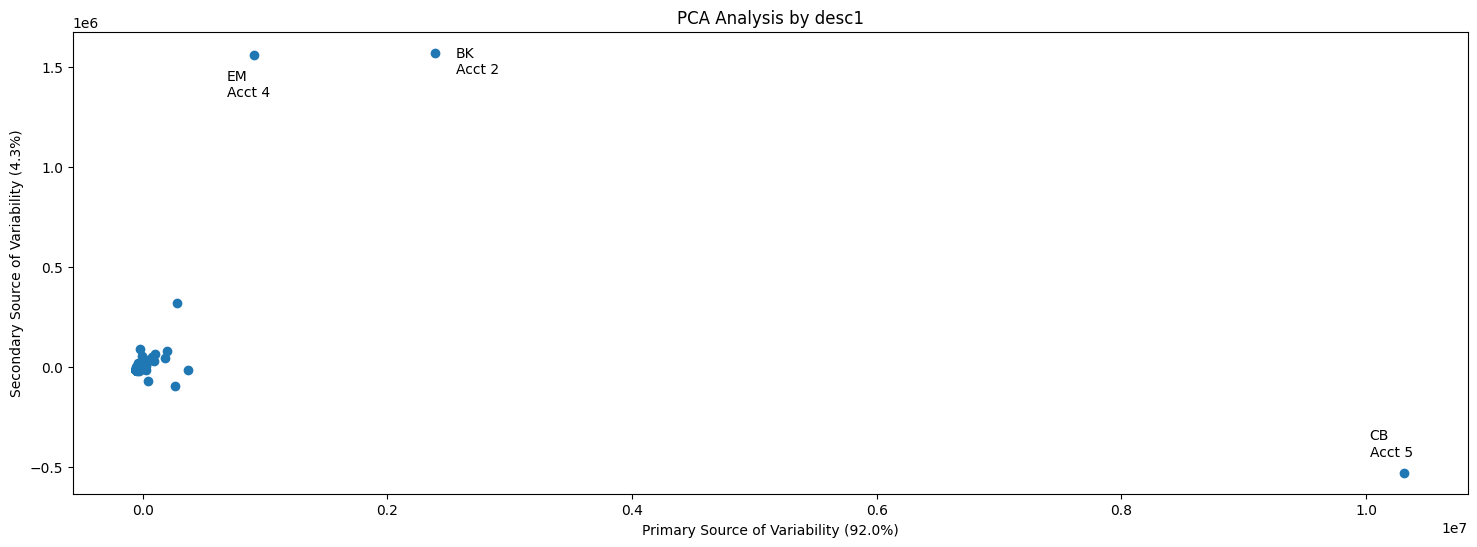

In [8]:
pca = PCA(n_components=2, random_state=0)
X_trends = df_trends.drop("trends", axis = 1).sum(axis = 1).unstack("desc1").reset_index().drop(["fyear", "Period"], axis = 1).T.fillna(0)
X_pca = pca.fit_transform(X_trends)
X_trends["pca1"], X_trends["pca2"] = X_pca[:,0], X_pca[:,1]
X_trends["pca_tuple"] = X_trends.apply(lambda x: (x.pca1, x.pca2), axis = 1)
plt.figure(figsize = (18,6))
plt.scatter(x = X_trends.pca1, y = X_trends.pca2)
plt.title("PCA Analysis by desc1")
plt.xlabel(f"Primary Source of Variability ({round(pca.explained_variance_ratio_[0]*100, 1)}%)")
plt.ylabel(f"Secondary Source of Variability ({round(pca.explained_variance_ratio_[1]*100, 1)}%)")

for desc1, acct, offset in zip(["CB", "EM", "BK"], ["Acct 5", "Acct 4", "Acct 2"], [(-25, 12), (-20, -30), (15, -15)]):
    plt.annotate(f"{desc1}\n{acct}", xy = X_trends.pca_tuple[desc1], xytext = offset, textcoords = "offset points") #TODO: Adjust annotation for aesthics

In [174]:
pd.options.display.float_format = '{:,.0f}%'.format
print_str = "Top 3 desc1s constituent accounts"
print(print_str)
print("-"*len(print_str))
display(pd.concat([
            (dh.df.query("desc1 == 'CB'").groupby("Account").txn_amt.sum()/dh.df.query("desc1 == 'CB'").txn_amt.sum()).sort_values(ascending = False).rename("CB").head(2),
            (dh.df.query("desc1 == 'EM'").groupby("Account").txn_amt.sum()/dh.df.query("desc1 == 'EM'").txn_amt.sum()).sort_values().rename("EM").tail(1),
            (dh.df.query("desc1 == 'BK'").groupby("Account").txn_amt.sum()/dh.df.query("desc1 == 'BK'").txn_amt.sum()).sort_values().rename("BK").tail(1)
        ], axis = 1).fillna(0)*100
)
pd.options.display.float_format = '{:,.2f}'.format

Top 3 desc1s constituent accounts
---------------------------------


,CB,EM,BK
Account,,,
Acct 5,59%,0%,0%
Acct 4,42%,102%,0%
Acct 2,0%,0%,95%


['Acct 5', 'Acct 4', 'Acct 2']

In [7]:
TOP3_DESC1_LIST = ["CB", "EM", "BK"]

In [9]:
dh.df.groupby(["period_fyear", "desc1"]).txn_amt.sum().reset_index().groupby("desc1").txn_amt.agg(["sum", "std"]).sort_values("sum", ascending = False).head(10)

,sum,std
desc1,,
CB,"56,456,893.72","916,072.58"
BK,"19,422,808.07","165,409.95"
EM,"7,735,422.08","297,294.39"
AD,"4,293,716.14","81,708.43"
CI,"2,848,992.38","203,967.17"
DM,"1,709,711.51","78,819.04"
GY,"1,702,654.34","132,016.93"
CG,"1,584,250.33","22,481.01"
AJ,"1,289,080.22","10,934.96"


## PCA (Account)

In [31]:
#Sandbox (delete when done)
pca = PCA(n_components=2, random_state=0)
X_trends = df_trends.drop("trends", axis = 1).sum(axis = 1).unstack("desc1").reset_index().drop(["fyear", "Period"], axis = 1).T.fillna(0)
X_pca = pca.fit_transform(X_trends)
X_trends["pca1"], X_trends["pca2"] = X_pca[:,0], X_pca[:,1]
X_trends["pca_tuple"] = X_trends.apply(lambda x: (x.pca1, x.pca2), axis = 1)
plt.figure(figsize = (18,6))
plt.scatter(x = X_trends.pca1, y = X_trends.pca2)
plt.title("PCA Analysis by desc1")
plt.xlabel(f"Primary Source of Variability ({round(pca.explained_variance_ratio_[0]*100, 1)}%)")
plt.ylabel(f"Secondary Source of Variability ({round(pca.explained_variance_ratio_[1]*100, 1)}%)")

for acct, offset in zip(["Acct 5", "Acct 4", "Acct 2"], [(-25, 12), (-20, -30), (15, -15)]):
    plt.annotate(f"{acct}", xy = X_trends.pca_tuple[acct], xytext = offset, textcoords = "offset points") #TODO: Adjust annotation for aesthics

X_trends

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
desc1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AA,-32.93,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,560.97",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"7,835.41",0.00,0.00,"4,328.92",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,307.37",0.00,0.00,0.00,0.00,0.00,"7,868.34",0.00,0.00,"1,560.33",0.00,0.00
AB,"1,797.68","1,989.70","2,055.58",-41.11,"4,749.57",-95.00,0.00,0.00,"3,021.68",0.00,"3,310.67",-66.21,"3,083.37",-61.68,0.00,"1,704.06","1,749.80","2,994.17","1,726.72",629.66,"1,301.38","2,550.81","4,744.31","6,148.69",-123.15,898.30,"2,173.45","3,681.41",898.30,-92.46,"3,089.71",0.00,"8,573.67","3,359.92","4,355.87",-87.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,865.64","5,505.69","3,111.27",0.00
AC,"10,803.99","9,977.31","10,639.95","6,342.93","6,875.81","3,953.82",-52.09,0.00,0.00,"6,564.55","3,489.30","10,608.05","5,157.46","8,269.15","7,781.53",-242.65,-69.02,"3,114.56","5,561.38","18,814.57","18,540.99","12,213.31","5,301.73","20,977.97","11,302.87","3,205.20","15,165.64",-205.26,"9,024.79","3,047.92","13,457.87","7,019.05","15,856.82","4,343.38","13,982.77","12,224.07","14,608.94","3,167.83","18,924.57","8,597.64","5,997.76","8,153.29","5,440.25","17,498.05","7,014.72","10,974.74","7,533.38"
AD,"188,698.66","216,077.87","126,605.53","86,274.34","206,333.28","218,854.68","250,159.14","256,698.95","220,427.79","159,033.68","231,418.43","162,147.04","248,978.10","143,029.84","256,092.19","84,746.30","111,814.62","138,873.43","144,591.16","296,746.28","124,281.86","129,227.79","81,651.69","54,733.69","55,381.35","46,728.44","20,688.93","26,900.84","6,520.24",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
AE,"28,903.77","31,044.42","29,362.89","16,930.15","10,065.77","5,069.57",0.00,0.00,0.00,"14,157.31",-60.24,"3,614.63","6,347.53","6,245.27",0.00,0.00,0.00,"2,710.98","4,627.83","14,945.99","31,459.22","31,696.91","12,343.62","46,249.33","29,624.61","5,422.09","14,604.59",-146.04,"21,077.56",-194.43,"11,747.57","52,235.55","9,646.61",0.00,"-4,823.15","29,011.75","40,815.77","12,806.46","50,992.14","16,859.76",-168.60,"33,395.03","10,874.41","1,019.79",0.00,940.45,940.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NM,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"6,664.22","-1,072.13",0.00
NN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,92.46,"1,017.10"
NO,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,298.07",0.00


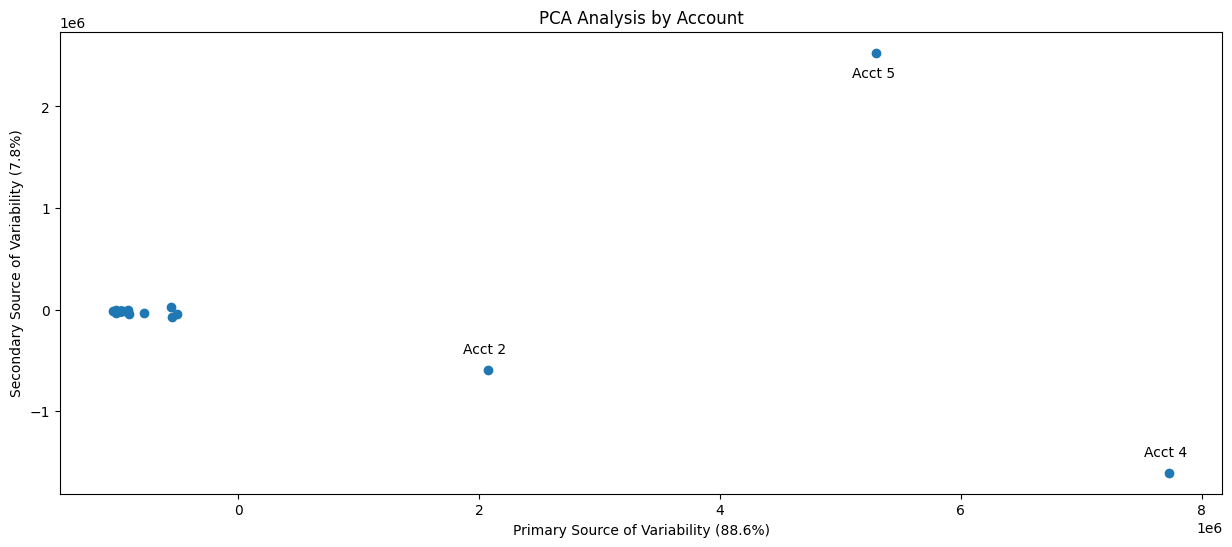

In [66]:
pca = PCA(n_components=2, random_state=0)
X_trends = df_trends.drop("trends", axis = 1).groupby(["fyear", "Period"]).sum().reset_index(drop = True).T
X_pca = pca.fit_transform(X_trends)
X_trends["pca1"], X_trends["pca2"] = X_pca[:,0], X_pca[:,1]
X_trends["pca_tuple"] = X_trends.apply(lambda x: (x.pca1, x.pca2), axis = 1)

plt.figure(figsize = (15,6))
plt.scatter(x = X_trends.pca1, y = X_trends.pca2)
plt.title("PCA Analysis by Account")
plt.xlabel(f"Primary Source of Variability ({round(pca.explained_variance_ratio_[0]*100, 1)}%)")
plt.ylabel(f"Secondary Source of Variability ({round(pca.explained_variance_ratio_[1]*100, 1)}%)")

for acct, offset in zip(X_trends.pca1.sort_values().tail(3).index, [(-18, 12), (-17, -18), (-18, 12)]):
    plt.annotate(f"{acct.replace('_', ' ')}", xy = X_trends.pca_tuple[acct], xytext = offset, textcoords = "offset points") #TODO: Adjust annotation for aesthics

In [49]:
a, b, c = X_trends.pca1.sort_values().tail(3).index
acct = c
X_trends.pca_tuple[acct]

(7732870.687000813, -1607906.303579301)

## KMeans

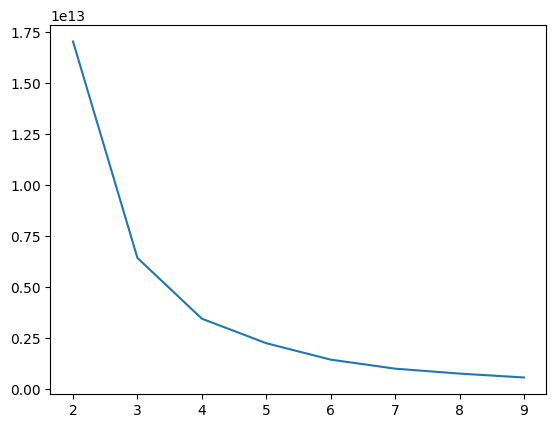

In [11]:
X = dh.df.pivot_table(index = "desc1", columns = "period_fyear", values = "txn_amt", aggfunc = "sum")
km_inertias = [KMeans(n_clusters = i).fit(X.fillna(0)).inertia_ for i in range(2,10)]
plt.plot(range(2,10), km_inertias)

In [12]:
km = KMeans(n_clusters = 4)
X = dh.df.pivot_table(index = "desc1", columns = "period_fyear", values = "txn_amt", aggfunc = "sum")
km.fit(X.fillna(0))
X["clusters"] = km.labels_
X.query("clusters > 0") #displaying desc1s with clusters != 0

period_fyear,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,clusters
desc1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BK,"823,757.62","666,097.41","363,714.52","267,251.53","403,891.07","503,740.67","395,775.33","204,629.87","342,665.14","468,016.04","389,758.63","348,429.40","397,293.37","369,596.38","303,135.83","270,976.48","357,539.27","233,389.74","283,544.40","389,821.23","519,953.48","373,633.59","287,216.72","140,541.56","418,352.33","415,701.36","149,225.88","471,039.59","246,082.16","559,160.32","491,473.83","291,289.97","635,371.16","560,823.63","215,041.66","476,784.17","529,498.12","382,247.74","221,611.82","232,013.73","346,387.85","443,824.56","687,858.62","711,288.77","854,416.51","368,481.13","610,463.88",2
CB,"753,341.27","995,283.77","848,743.72","289,182.68",NaN,"310,245.21","408,525.52","35,731.64",NaN,"215,365.36","173,712.33","860,321.70","355,998.99","1,073,096.78","581,991.85","943,894.06","1,672,797.48","396,133.00","1,505,145.52","1,029,762.63","2,241,902.00","1,397,086.50","368,255.52","2,510,465.28","2,540,571.06","3,806,621.36","2,276,757.39","2,845,284.63","213,988.22","2,657,414.37","2,047,249.00","1,528,329.67","1,297,245.59","1,995,856.76","870,961.77","2,796,313.76","983,497.43","2,309,762.63","1,527,496.79","660,858.47","-4,624.00","635,921.48","937,309.21","890,028.77","1,457,521.95","723,992.61","2,491,551.99",1
EM,"185,639.46","428,053.65",NaN,"-6,188.00",NaN,NaN,NaN,"250,364.32","57,638.92","-1,392.30",NaN,-249.73,"258,330.48","123,352.84","-2,906.19",NaN,NaN,NaN,NaN,"129,165.24","85,679.61","-1,824.45",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"500,159.64","572,266.04","829,848.22","10,657.28",NaN,"333,439.76","168,895.54","970,168.36","233,644.61","-5,156.40",NaN,"166,719.88","825,263.45","821,929.06","491,823.67","310,099.12",NaN,NaN,3


In [ ]:
# #plotly references: 
# #https://plotly.com/python/reference/pie/#pie-texttemplate
# #https://dash.plotly.com/dash-ag-grid/d3-value-formatters


# # X.clusters.replace({0:"Other", 1: "CB", 2:"BK", 3:"EM"})
# #df_clusters = X.assign(clusters = X.clusters.replace({0:"Other<br>123", 1: "CB", 2:"BK", 3:"EM"})).groupby("clusters").sum().sum(axis = 1).reset_index(name = "txn_amt")

# df_clusters = (X
#                 .groupby("clusters")
#                 .sum()
#                 .sum(axis = 1)
#                 .reset_index(name = "txn_amt")
#                 .assign(cluster_labels = ["Other", "CB", "BK", "EM"])
#                 #.assign(label = lambda y: y.apply(lambda x: f"{x.cluster_labels}<br>${x.txn_amt:,.02f}", axis = 1))
#                )

# fig = px.treemap(
#                     data_frame = df_cluster_accounts,
#                     path = ["clusters", "Account"],
#                     values = df_cluster_accounts.txn_amt,
#                     title = "Total Desc1s by Total Transaction Amount",
#                     #width = 1500,
#                     #height = 500,
#                     #labels = df_clusters.txn_amt,
#                     #template = "seaborn"
# )
# #fig.data[0].textinfo = "label + text + current path"
# # fig.update_layout(title_font_color = "red", margin = dict(t = 50, r = 50, l = 50, b = 10))
# # fig.update_traces(textfont = dict(color = "white", size = 15), textinfo = "label + value", texttemplate = "<b>%{label}</b> (%{percentRoot})<br>%{value:$,}")
# fig.show()

# #fig.data[0]["textfont"]["color"] = "white" #alternative to update_traces

In [ ]:
# cluster_labels = ["Other", "CB", "BK", "EM"]
# def replace_labels(df):
#     df = df.copy()
#     df.clusters = df.clusters.replace({i:l for i, l in enumerate(cluster_labels)})
#     return df


# df_cluster_accounts = (dh.df
#                             .merge(X.clusters, left_on = "desc1", right_index = True)
#                             .groupby(["clusters", "Account"])
#                             .txn_amt
#                             .sum()
#                             .sort_values()
#                             .reset_index()
#                             #.pipe(replace_labels)
#                         )
# df_cluster_accounts

In [13]:
#plotly references: 
#https://plotly.com/python/reference/pie/#pie-texttemplate
#https://dash.plotly.com/dash-ag-grid/d3-value-formatters

def replace_labels(df):
    df = df.copy()
    df.clusters = df.clusters.replace({i:l for i, l in enumerate(cluster_labels)})
    df = df.merge(df.groupby("clusters").txn_amt.sum().reset_index().assign(pct = lambda x: x.txn_amt/x.txn_amt.sum()).assign(cluster_labels = lambda x: x.clusters + " (" + (x.pct*100).round(0).astype(int).astype(str) + "%)").drop("txn_amt", axis = 1), on = "clusters")
    return df

def condense_accounts(df):
    total = 0
    result_list = []
    total_pct = 0
    for i, row in df.iterrows():
        #print(i)
        total += row.txn_amt
        total_pct += row.pct
        if total_pct >= 0.05:
            if len(result_list) == 0:
                result_list += [[row.Account + " & others", total]]
            else:
                result_list += [[row.Account, row.txn_amt]]
        
    return result_list

cluster_labels = ["Other", "CB", "BK", "EM"]

df_cluster_accounts = (dh.df
                            .merge(X.clusters, left_on = "desc1", right_index = True)
                            .groupby(["clusters", "Account"])
                            .txn_amt
                            .sum()
                            .sort_values()
                            .reset_index()
                            .assign(pct = lambda x: x.txn_amt/x.txn_amt.sum())
                            .groupby("clusters")
                            .apply(lambda x: condense_accounts(x)).explode().apply(lambda x: pd.Series(x, index = ["Account", "txn_amt"]))
                            .reset_index()
                            .pipe(replace_labels)
                        )

fig = px.treemap(
                    data_frame = df_cluster_accounts,
                    path = ["cluster_labels", "Account"],
                    values = df_cluster_accounts.txn_amt,
                    title = "Total Desc1s by Total Transaction Amount",
                    width = 2000,
                    height = 600,
                    #labels = df_clusters.txn_amt,
                    template = "seaborn"
)
#fig.data[0].textinfo = "label + text + current path"
fig.update_layout(title_font_color = "black", title_font_size = 30, margin = dict(t = 100, r = 50, l = 50, b = 10))
fig.update_traces(textfont = dict(color = "white", size = 15), textinfo = "label + value", texttemplate = "<b>%{label}</b> (%{percentRoot})<br>%{value:$,}")
fig.show()

#fig.data[0]["textfont"]["color"] = "white" #alternative to update_traces
#.explode()

In [352]:
# def replace_labels(df):
#     df = df.copy()
#     df.clusters = df.clusters.replace({i:l for i, l in enumerate(cluster_labels)})
#     df = df.drop("txn_amt", axis = 1).merge(df.groupby("clusters").txn_amt.sum().reset_index().assign(pct = lambda x: x.txn_amt/x.txn_amt.sum()).assign(cluster_labels = lambda x: x.clusters + " (" + (x.pct*100).round(0).astype(int).astype(str) + "%)"), on = "clusters")
#     return df

df_cluster_accounts.pipe(replace_labels)
# df = df_cluster_accounts.copy()
# df.clusters = df.clusters.replace({i:l for i, l in enumerate(cluster_labels)})
# df.merge(df.groupby("clusters").txn_amt.sum().reset_index().assign(pct = lambda x: x.txn_amt/x.txn_amt.sum()).assign(cluster_labels = lambda x: x.clusters + " (" + (x.pct*100).round(0).astype(int).astype(str) + "%)"), on = "clusters")

,clusters,Account,txn_amt,pct,cluster_labels
0,Other,Acct 6 & others,"39,368,520.85",0.32,Other (32%)
1,Other,Acct 5,"39,368,520.85",0.32,Other (32%)
2,Other,Acct 2,"39,368,520.85",0.32,Other (32%)
3,Other,Acct 4,"39,368,520.85",0.32,Other (32%)
4,CB,Acct 4 & others,"56,456,893.72",0.46,CB (46%)
5,CB,Acct 5,"56,456,893.72",0.46,CB (46%)
6,BK,Acct 2 & others,"19,422,808.07",0.16,BK (16%)
7,EM,Acct 4 & others,"7,735,422.08",0.06,EM (6%)


# <strong> Large Repeating Transactions Section </strong>

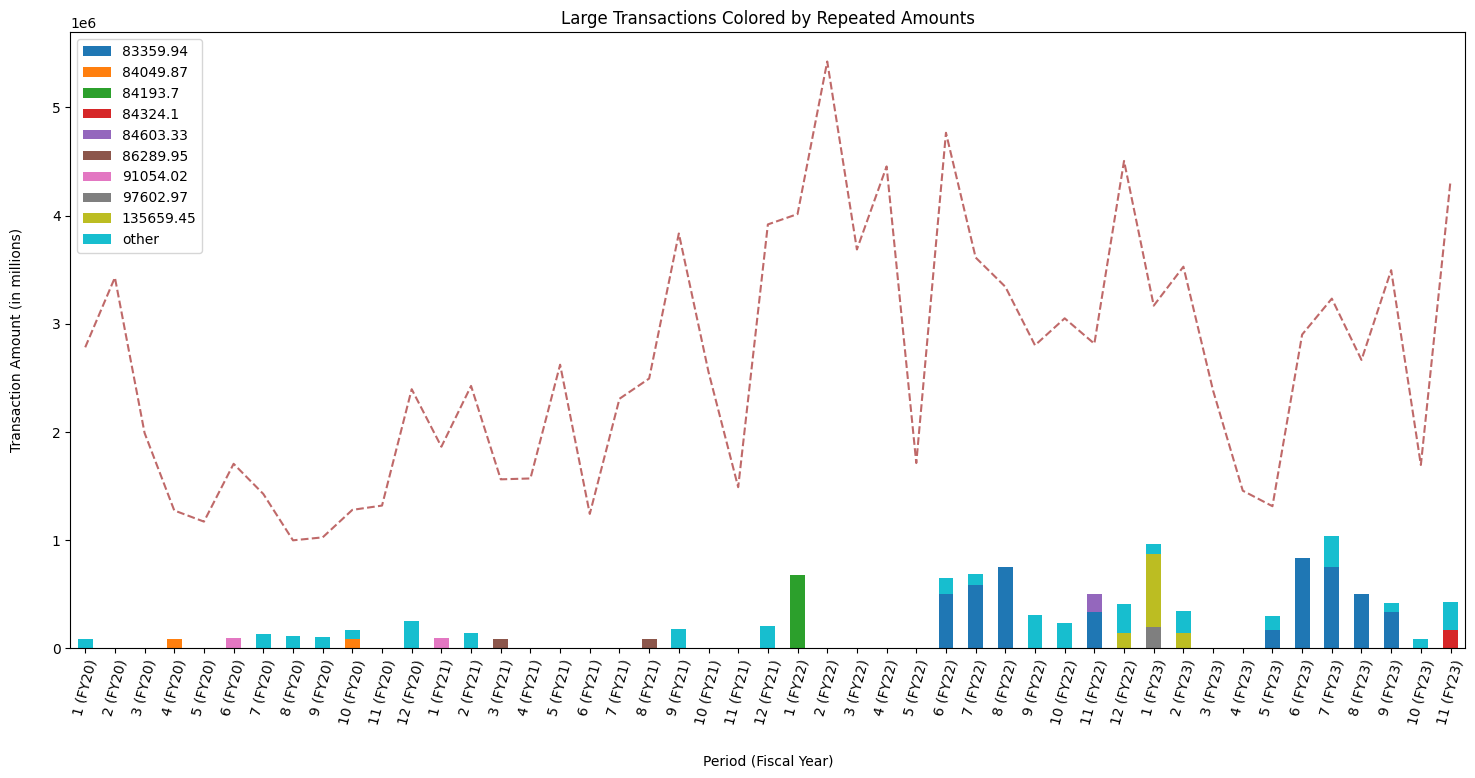

In [249]:
large_txns = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].Debit.value_counts().where(lambda x: x >= 2).dropna().index
large_txn_labels = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].Debit.apply(lambda x: -1*x if x in large_txns else np.inf).replace(np.inf, "other")

df_large_txns_crosstab = (dh.df
    .groupby("period_fyear")[["txn_amt"]]
    .sum()
    .join(pd.pivot_table(
                            data = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].eval("Debit = -1*Debit"), 
                            index = "period_fyear", 
                            columns = large_txn_labels, 
                            values = "Debit", 
                            aggfunc = "sum"
                        )
        )
                            .fillna(0)                  
)

(df_large_txns_crosstab
    .drop("txn_amt", axis = 1)
    .set_index(
                dh.df[["Period", "fyear", "period_fyear"]]
                    .drop_duplicates()
                    .apply(lambda x: str(x.Period) + " (FY" + str(x.fyear)[-2:]+")", axis = 1)
            )
    .shift(0)
    .plot(
            kind = "bar", 
            stacked = True, 
            figsize = (18,8), 
            zorder = 2
        )
)
plt.plot(dh.df.groupby("period_fyear").txn_amt.sum(), color = "brown", linestyle = "dashed", alpha = 0.7, zorder = 1)
plt.title("Large Transactions Colored by Repeated Amounts")
plt.ylabel("Transaction Amount (in millions)", labelpad=20)
plt.xlabel("Period (Fiscal Year)", labelpad=20)
plt.xticks(rotation = 75);

In [264]:
pd.pivot_table(
                            data = dh.df.query("Debit <= Debit.quantile(0.001)")[["period_fyear", "Debit"]].eval("Debit = -1*Debit"), 
                            index = "period_fyear", 
                            columns = large_txn_labels, 
                            values = "Debit", 
                            aggfunc = "count"
                        ).sum().sort_values(ascending = False).to_frame(name = "freq").pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Large_txn_freq", "Large Transactions by Frequency")

In [129]:
#*
print_str = "Top 3 desc1s large repeating transaction amounts"
print(print_str)
print("-"*len(print_str))
(dh.df
    .query("Debit in @large_txns and desc1 in @TOP3_DESC1_LIST")[["desc1", "Debit"]]
    .set_index("desc1")
    .squeeze()
    .apply(np.abs)
    .reset_index()
    .value_counts()
    .sort_index()
    .to_frame()
)

Top 3 desc1s large repeating transaction amounts
------------------------------------------------


count
desc1 Debit            
BK    84,049.87       2
      91,054.02       2
CB    84,193.70       8
EM    83,359.94      57
      97,602.97       2
      135,659.45      7

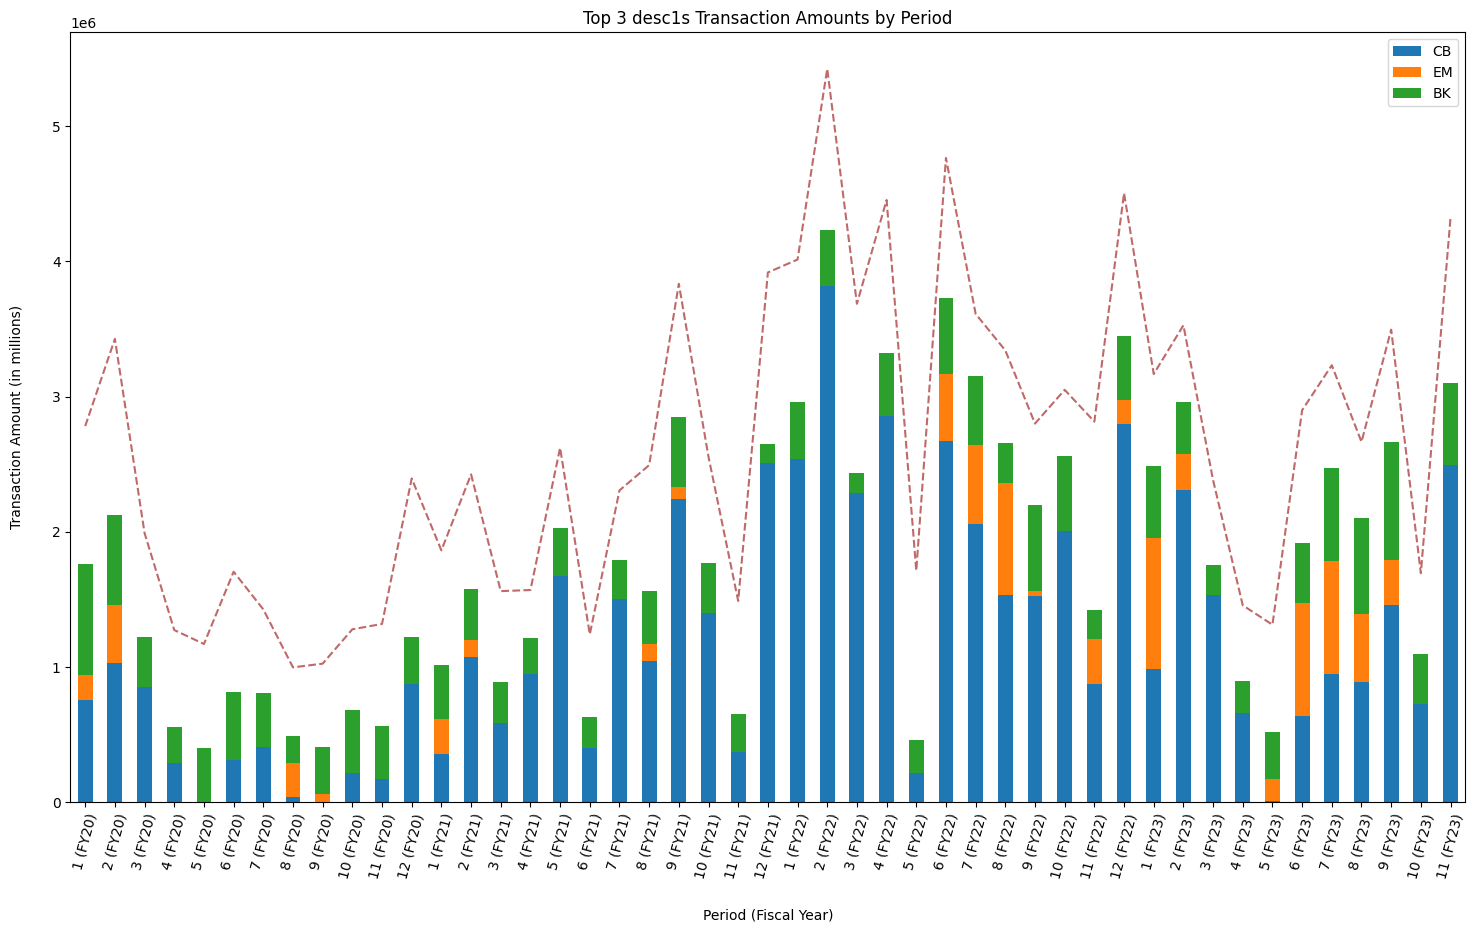

In [133]:
df_top3_desc1_crosstab = (dh.df
    .groupby("period_fyear")[["txn_amt"]]
    .sum()
    .join(dh.df.query("desc1 in @TOP3_DESC1_LIST")[["desc1", "period_fyear", "Debit"]].eval("Debit = -1*Debit").pivot_table(index = "period_fyear", columns = "desc1", values = "Debit", aggfunc = "sum")
        )
    .fillna(0)                  
)

(df_top3_desc1_crosstab
    .drop("txn_amt", axis = 1)
    .set_index(
                dh.df[["Period", "fyear", "period_fyear"]]
                    .drop_duplicates()
                    .apply(lambda x: str(x.Period) + " (FY" + str(x.fyear)[-2:]+")", axis = 1)
            )
    .shift(0)
    [["CB", "EM", "BK"]]
    .plot(
            kind = "bar", 
            stacked = True, 
            figsize = (18,10), 
            zorder = 2
        )
)
plt.plot(dh.df.groupby("period_fyear").txn_amt.sum(), color = "brown", linestyle = "dashed", alpha = 0.7, zorder = 1)
plt.title("Top 3 desc1s Transaction Amounts by Period")
plt.ylabel("Transaction Amount (in millions)", labelpad=20)
plt.xlabel("Period (Fiscal Year)", labelpad=20)
plt.xticks(rotation = 75);

# <strong> Time Series </strong>

period_fyear,0,1,2,3,4
desc1,,,,,
AA,-32.93,NaN,NaN,NaN,NaN
AB,"1,797.68","1,989.70","2,055.58",-41.11,"4,749.57"
AC,"10,803.99","9,977.31","10,639.95","6,342.93","6,875.81"
AD,"188,698.66","216,077.87","126,605.53","86,274.34","206,333.28"
AE,"28,903.77","31,044.42","29,362.89","16,930.15","10,065.77"
AF,"10,566.12",NaN,"3,012.25",NaN,"2,761.65"
AG,409.55,335.92,NaN,NaN,NaN
AH,"1,115.95","1,428.91",45.77,"1,233.47",565.89
AI,114.49,NaN,NaN,NaN,NaN


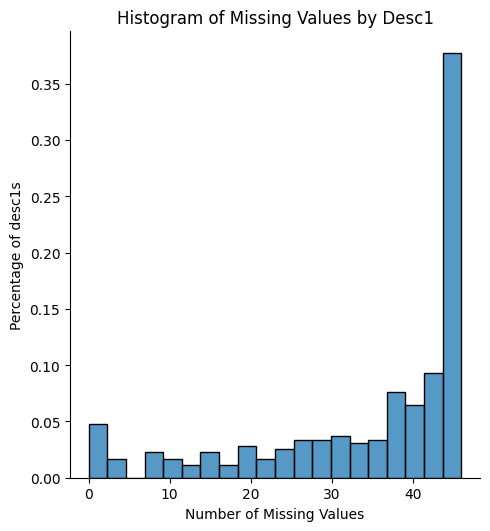

In [278]:
imputer = KNNImputer(n_neighbors = 3)
X = dh.df.pivot_table(index = "desc1", columns = "period_fyear", values = "txn_amt", aggfunc = "sum")
#X.isna().sum(axis = 1).sort_values(ascending = False)
sns.displot(data = X.isna().sum(axis = 1).sort_values(ascending = False), stat = "probability", bins = 20)
plt.title("Histogram of Missing Values by Desc1")
plt.xlabel("Number of Missing Values")
plt.ylabel("Percentage of desc1s")
display(X.head(10).T.head(5).T)

In [299]:
(X.isna().sum(axis = 1).sort_values(ascending = False) > 43).sum()/355

0.37746478873239436

In [295]:
X.head(10).T.head(5).T.set_axis(["P1", "P2", "P3", "P4", "P5"], axis = 1).round(2).fillna("NA").astype(str).pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Time Series Pivot Table", "Desc1 Transactions by First 5 Time Periods")

# <strong> Seasonal Decomposition EDA </strong>

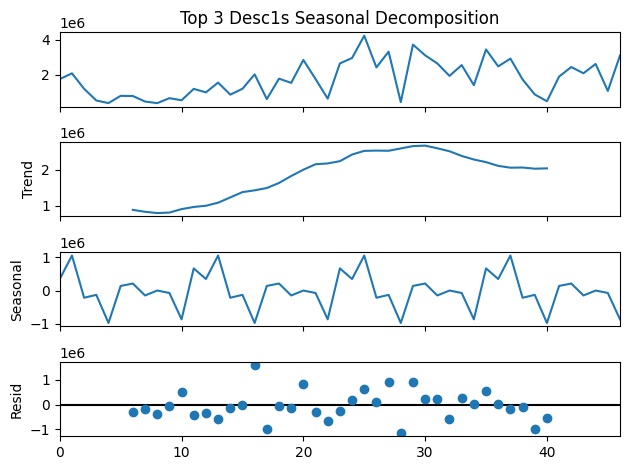

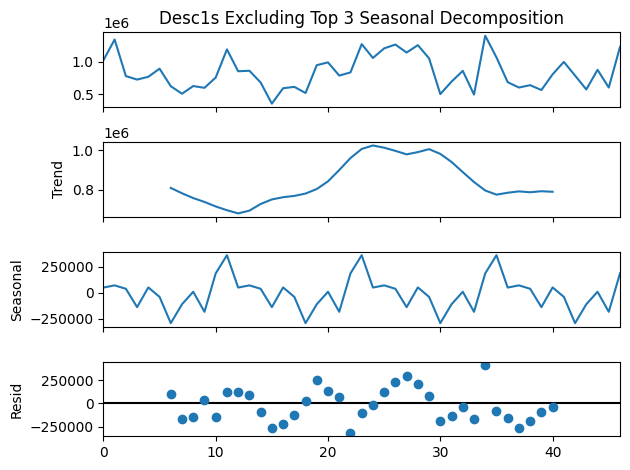

In [147]:
seasonal_decompose(dh.df.query("desc1 in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Top 3 Desc1s Seasonal Decomposition"), period = 12).plot()
plt.show()
seasonal_decompose(dh.df.query("desc1 not in @TOP3_DESC1_LIST").groupby("period_fyear").txn_amt.sum().rename("Desc1s Excluding Top 3 Seasonal Decomposition"), period = 12).plot();

In [151]:
dh.df.describe(include = "all")

,desc1,desc2,Description,Period,Date,Organization,Account,Debit,Credit,Balance,fyear,txn_type,txn_amt,month,day_of_week,week,week_fyear,month_fyear,period_fyear
count,76722,"76,724.00",76724,"76,724.00",76724,76724,76724,"73,564.00","3,160.00","76,724.00","76,724.00",76724,"76,724.00","76,724.00","76,724.00","76,724.00","76,724.00","76,724.00","76,724.00"
unique,354,NaN,13947,NaN,NaN,4,20,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,AU,NaN,KL 05827,NaN,NaN,Dept C,Acct 4,NaN,NaN,NaN,NaN,Debit,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,6640,NaN,100,NaN,NaN,50383,49691,NaN,NaN,NaN,NaN,73564,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,"6,986.23",NaN,6.38,2021-09-27 00:36:11.148532224,NaN,NaN,"-1,688.16",380.99,"-3,329,835.06","2,021.51",NaN,"1,602.94",6.83,2.14,27.89,104.70,24.39,23.48
min,NaN,0.00,NaN,1.00,2019-09-28 00:00:00,NaN,NaN,"-193,001.03",0.02,"-12,005,610.65","2,020.00",NaN,"-142,779.98",1.00,0.00,1.00,0.00,0.00,0.00
25%,NaN,"3,450.00",NaN,3.00,2020-10-29 00:00:00,NaN,NaN,-534.28,31.99,"-4,982,927.33","2,021.00",NaN,50.18,4.00,1.00,15.00,57.00,13.00,13.00
50%,NaN,"6,782.00",NaN,6.00,2021-10-14 00:00:00,NaN,NaN,-127.43,67.45,"-2,805,944.97","2,022.00",NaN,116.57,7.00,2.00,29.00,107.00,25.00,24.00
75%,NaN,"10,677.00",NaN,9.00,2022-09-08 00:00:00,NaN,NaN,-56.64,181.77,"-911,614.10","2,022.00",NaN,488.19,10.00,3.00,42.00,154.00,36.00,35.00
max,NaN,"13,946.00",NaN,12.00,2023-08-25 00:00:00,NaN,NaN,-0.05,"142,779.98","155,645.47","2,023.00",NaN,"193,001.03",12.00,5.00,53.00,204.00,47.00,46.00


# <strong> Feature Summary </strong>

## Category Summaries

In [316]:
display(dh.df[["desc1", "Description", "Organization", "Account"]].apply(lambda x: x.nunique()).to_frame(name = "Unique Counts"),
        pd.to_datetime(dh.df.Date.describe()[["min", "max"]]).dt.strftime("%m/%d/%Y").to_frame(name = "Date Range")
)

,Unique Counts
desc1,355
Description,13947
Organization,4
Account,20


,Date Range
min,09/28/2019
max,08/25/2023


In [ ]:
(dh.df[["desc1", "Description", "Organization", "Account"]]
    .apply(lambda x: x.nunique())
    .to_frame(name = "Unique Counts")
    #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Unique Counts", " ")
)

(pd.to_datetime(dh.df.Date.describe()[["min", "max"]])
    .dt
    .strftime("%m/%d/%Y")
    .to_frame(name = "Date Range")
    #.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Date Range", " ")
)

## Example Dataset

In [266]:
dh.df.drop(["Organization", "Balance", "day_of_week", "month_fyear", "month", "txn_type"], axis = 1)[['desc1', 'desc2', 'Description', 'Account', 'Debit',
       'Credit', 'txn_amt', 'Date', 'fyear', 'Period',
       'period_fyear', 'week', 'week_fyear']].sample(5, random_state = 0).fillna("--")#.pipe(write_or_append_to_excel, "data/visualizations_public.xlsx", "Sample Transformed Data", "Sample Transformed Data")

,desc1,desc2,Description,Account,Debit,Credit,txn_amt,Date,fyear,Period,period_fyear,week,week_fyear
28727,AU,5324,AU 05324,Acct 4,-74.91,--,74.91,2021-06-07,2021,9,20,23,89
53577,BR,9866,BR 09866,Acct 4,-79.62,--,79.62,2022-06-17,2022,9,32,24,142
36992,CV,6521,CV 06521,Acct 4,-55.55,--,55.55,2021-09-21,2021,12,23,38,104
33942,CA,6040,CA 06040,Acct 6,-475.62,--,475.62,2021-08-09,2021,11,22,32,98
53920,FS,9940,FS 09940,Acct 9,-395.67,--,395.67,2022-06-28,2022,9,32,26,144


## Transaction by Groups (Acct, Org, Desc1)

### Organization

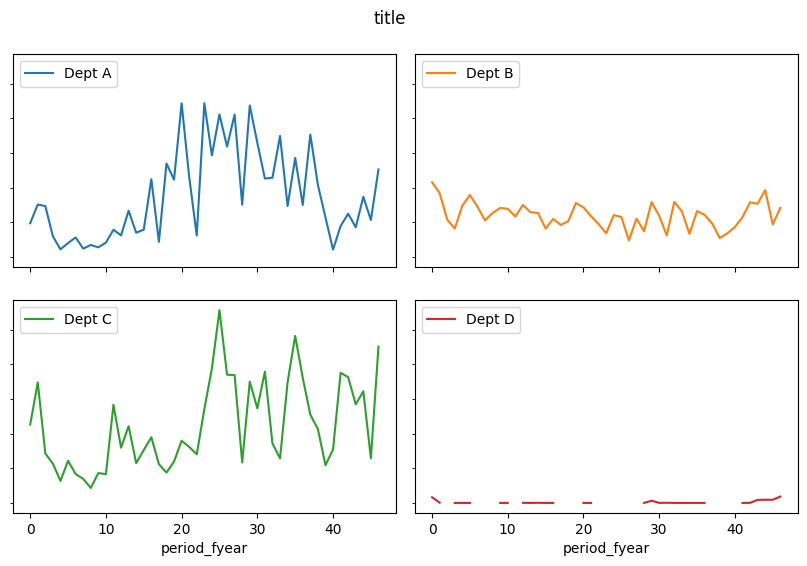

In [180]:
axs = dh.df.pivot_table(columns = "Organization", index = "period_fyear", values = "txn_amt", aggfunc = "sum").plot(figsize = (9,6), subplots = True, sharex = True, sharey = True, layout = (2,2))
plt.tight_layout(pad = 3, w_pad = 1, h_pad = 1)
plt.suptitle("title")
for ax in axs.ravel():
    #ax.axis("off")
    #ax.spines[["top", "right"]].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    # ax.set_xticklabels([])
    # ax.set_xticks([])
    ax.legend(loc = "upper left")

### Account

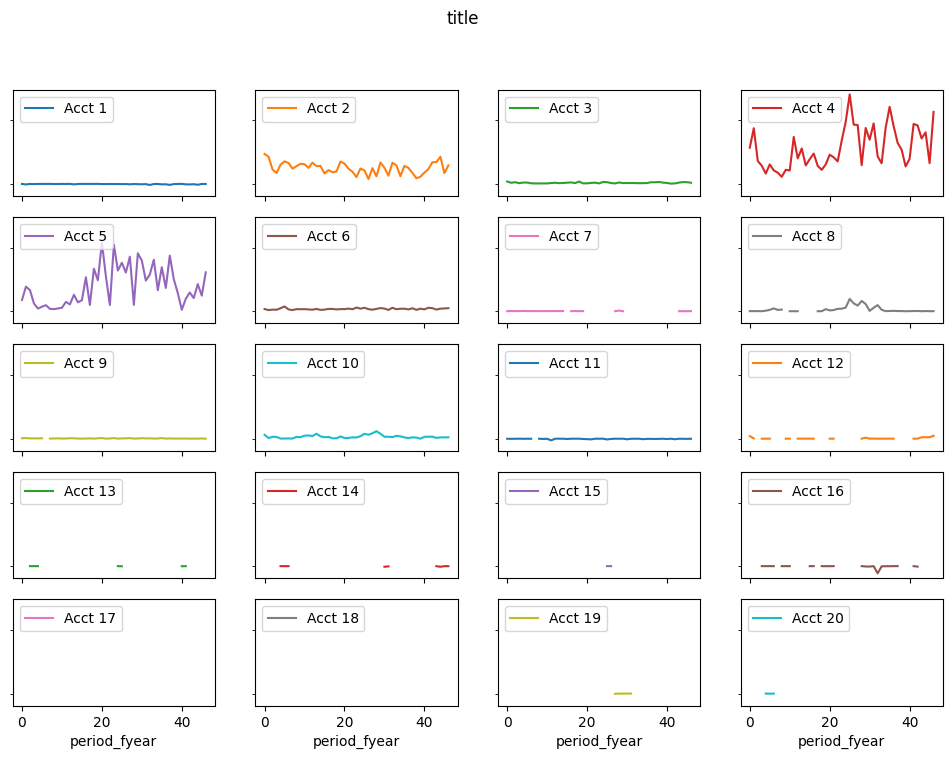

In [157]:
axs = dh.df.pivot_table(columns = "Account", index = "period_fyear", values = "txn_amt", aggfunc = "sum").sort_index(axis = 1, key = lambda x: x.str.split(expand = True).get_level_values(1).astype(int)).plot(figsize = (12,8), subplots = True, sharex = True, sharey = True, layout = (5,4))
#plt.tight_layout(pad = 2)
plt.suptitle("title")
for ax in axs.ravel():
    #ax.axis("off")
    #ax.spines[["top", "right"]].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    # ax.set_xticklabels([])
    # ax.set_xticks([])
    ax.legend(loc = "upper left")

### Desc1

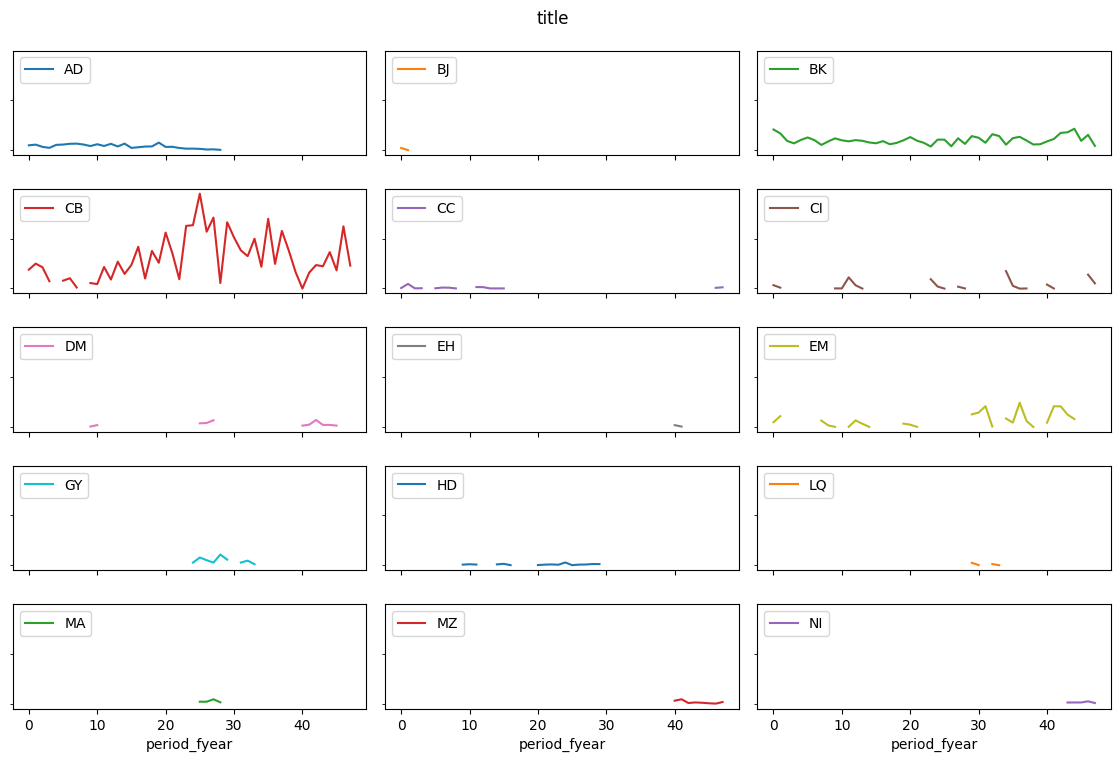

In [244]:
axs = dh.df.pivot_table(columns = "desc1", index = "period_fyear", values = "txn_amt", aggfunc = "sum").T.assign(sd = lambda x: x.std(axis = 1)).where(lambda x: x.sd > x.sd.quantile(0.95)).dropna(how = "all").T.plot(figsize = (12,8), subplots = True, sharex = True, sharey = True, layout = (5,3))
plt.tight_layout(pad = 3, w_pad = 1, h_pad = 1)
plt.suptitle("title")
for ax in axs.ravel():
    #ax.axis("off")
    #ax.spines[["top", "right"]].set_visible(False)
    ax.set_yticklabels([])
    ax.set_yticks([])
    # ax.set_xticklabels([])
    # ax.set_xticks([])
    ax.legend(loc = "upper left")

array([[<Axes: xlabel='period_fyear'>],
       [<Axes: xlabel='period_fyear'>],
       [<Axes: xlabel='period_fyear'>],
       [<Axes: xlabel='period_fyear'>]], dtype=object)

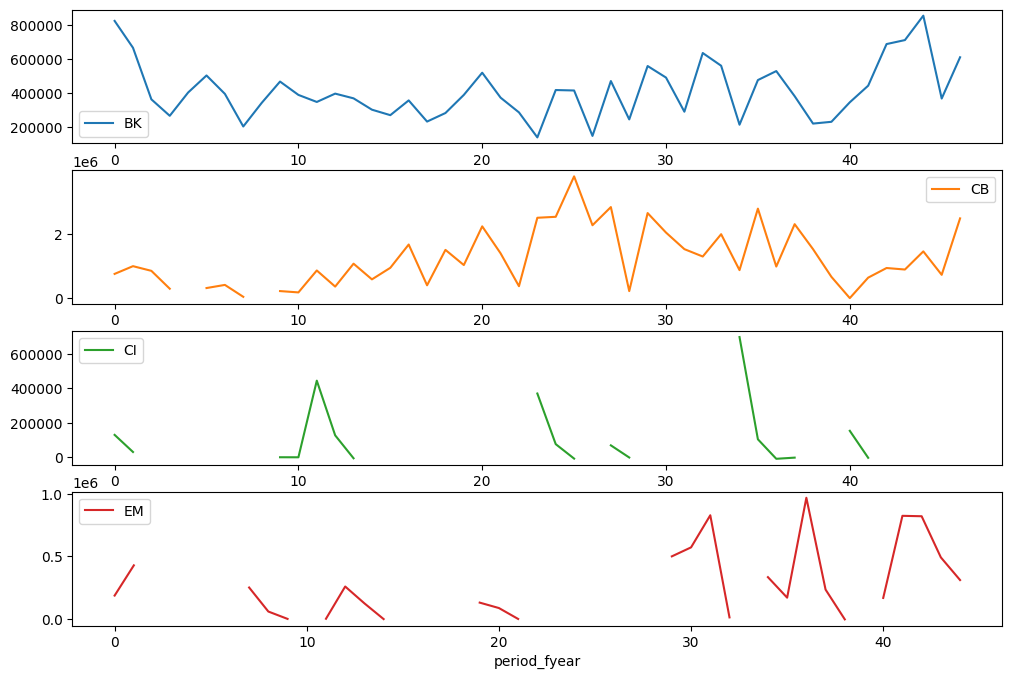

In [411]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12,8))

(dh.df
        .pivot_table(columns = "desc1", index = "period_fyear", values = "txn_amt", aggfunc = "sum")
        .T
        .apply(lambda x: x/x.sum())
        .query("desc1 in ['CB', 'EM', 'CI', 'BK']")
        .T
        .plot(ax = axs[0][0], subplots = True, layout = (4,1))
  )

(dh.df
        .pivot_table(columns = "desc1", index = "period_fyear", values = "txn_amt", aggfunc = "sum")
        .T
        .query("desc1 in ['CB', 'EM', 'CI', 'BK']")
        .T
        .plot(ax = axs[0][1], subplots = True, layout = (4,1))
  )
# plt.tight_layout(pad = 3, w_pad = 1, h_pad = 1)
# plt.suptitle("title")
# for ax in axs.ravel():
#     #ax.axis("off")
#     #ax.spines[["top", "right"]].set_visible(False)
#     ax.set_yticklabels([])
#     ax.set_yticks([])
#     # ax.set_xticklabels([])
#     # ax.set_xticks([])
#     ax.legend(loc = "upper left")

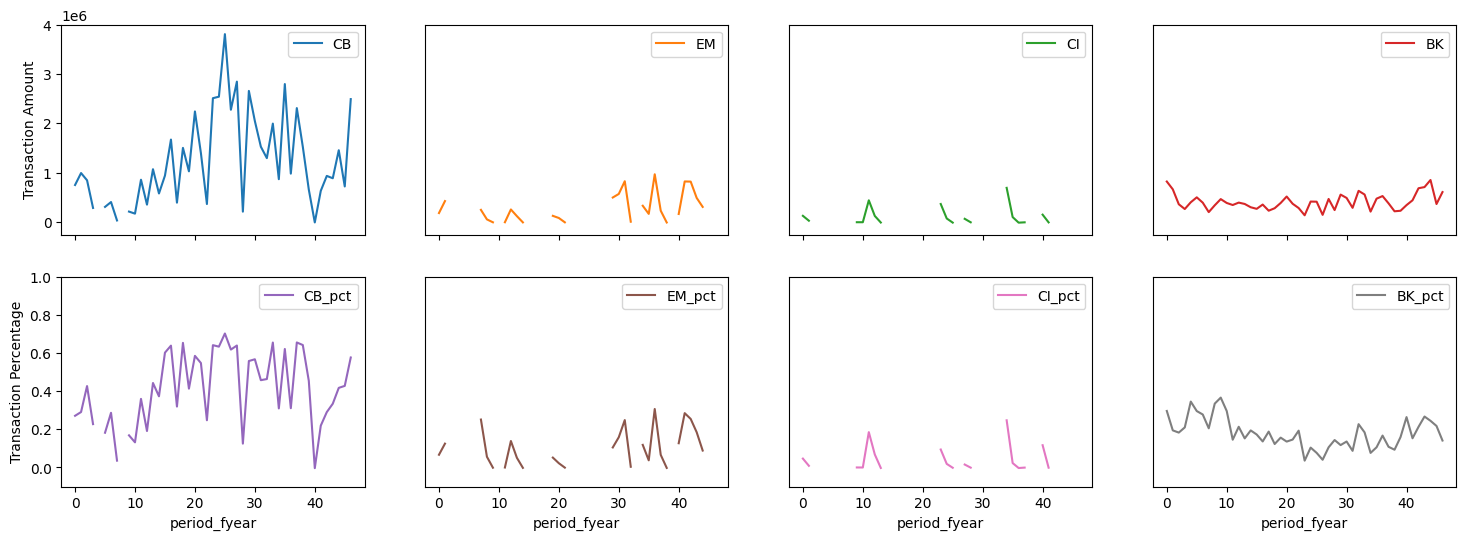

In [461]:
axs = pd.concat([(dh.df
        .pivot_table(columns = "desc1", index = "period_fyear", values = "txn_amt", aggfunc = "sum")
        .T
        #.apply(lambda x: x/x.sum())
        #.query("desc1 in ['CB', 'EM', 'CI', 'BK']")
        #.T
), (dh.df
        .pivot_table(columns = "desc1", index = "period_fyear", values = "txn_amt", aggfunc = "sum")
        .T
        .apply(lambda x: x/x.sum())
        .add_suffix("_pct", axis = 0)
)]).T[["CB", "EM", "CI", "BK", "CB_pct", "EM_pct", "CI_pct", "BK_pct"]].plot(subplots = True, layout = (2,4), figsize = (18,6), sharex = True)
#axs[1][0].set_ylim([0,1])
for ax in axs[1]:
        ax.set_ylim([-0.1,1])

for ax in axs[0]:
        ax.set_ylim([-0.25e6,4e6])

axs[0][0].set_ylabel("Transaction Amount")
axs[1][0].set_ylabel("Transaction Percentage")

for row, col in [(row, col) for col in [1,2,3] for row in [0,1]]:
        axs[row][col].set_yticklabels([])
        axs[row][col].set_yticks([])

In [462]:
dh.df.Account.nunique()

20

## COVID19 Effects Summary

In [295]:
(dh.df
    .groupby("Account")
    .apply(lambda x: pd.Series([x.query("fyear == 2020").txn_amt.mean(), x.query("fyear != 2020").txn_amt.mean()], index = ["fyear 2020", "others"]))
    .sort_index(axis = 0, key = lambda x: x.str.split(expand = True).get_level_values(1).astype(int))
    .eval("max_magnitude = 'fyear 2020'")
    .assign(max_magnitude = lambda x: x.max_magnitude.where(lambda y: abs(x["fyear 2020"]) > abs(x.others), "others"))
)


,fyear 2020,others,max_magnitude
Account,,,
Acct 1,-167.33,-221.43,others
Acct 2,"5,046.15","5,367.42",others
Acct 3,"1,402.72","2,263.35",others
Acct 4,739.00,"1,163.10",others
Acct 5,"1,124.78","3,321.88",others
Acct 6,"1,123.09","1,033.55",fyear 2020
Acct 7,"2,170.56","2,712.02",others
Acct 8,"2,900.81","4,765.31",others
Acct 9,496.17,515.93,others


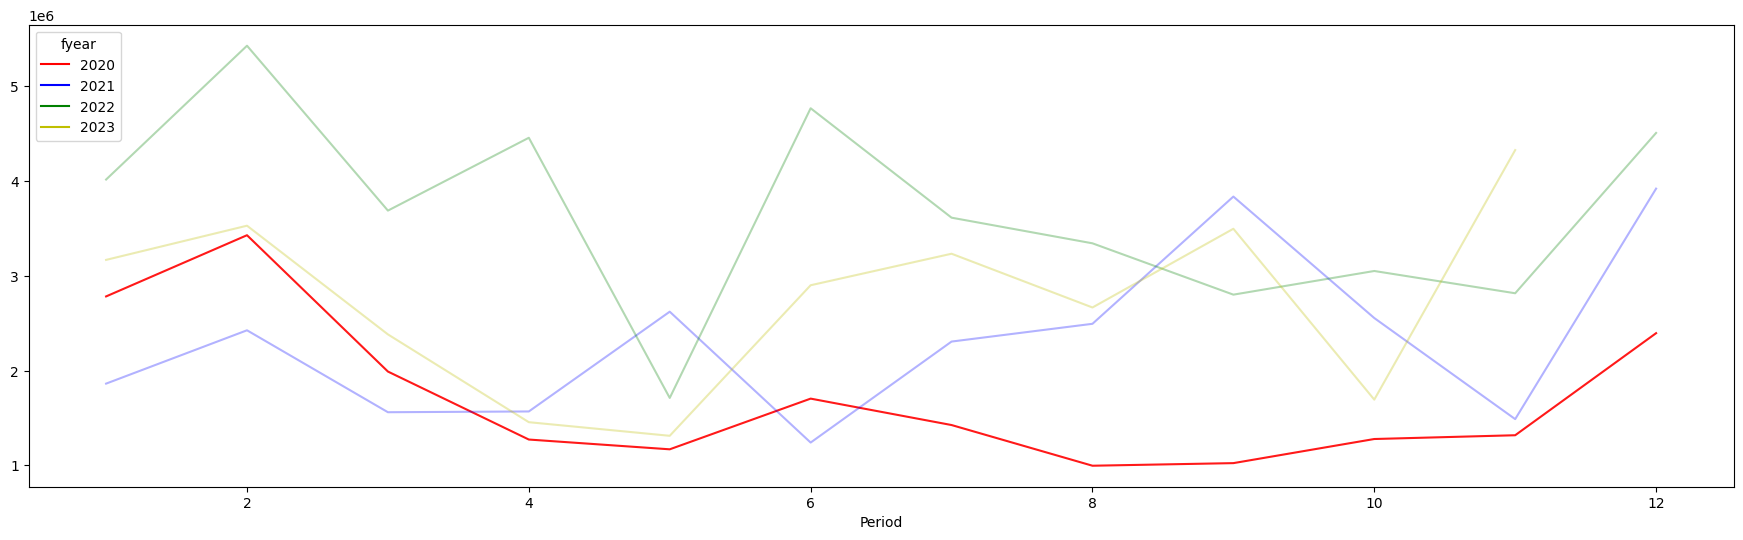

In [363]:
(dh.df
    .groupby(["Period", "fyear"])
    .txn_amt
    .sum()
    .unstack("fyear")
    .plot(figsize = (22,6), color = ["r", "b", "g", "y"])
    #.apply(lambda x: pd.Series([x.query("fyear == 2020").txn_amt.sum(), x.query("fyear != 2020").txn_amt.mean()], index = ["fyear 2020", "others"]))
    #.plot()
)

alphas = [0.9,0.3,0.3,0.3]
for l, a in zip(plt.gca().lines, alphas):
    l.set_alpha(a)


<Axes: title={'center': 'Transaction Sum'}>

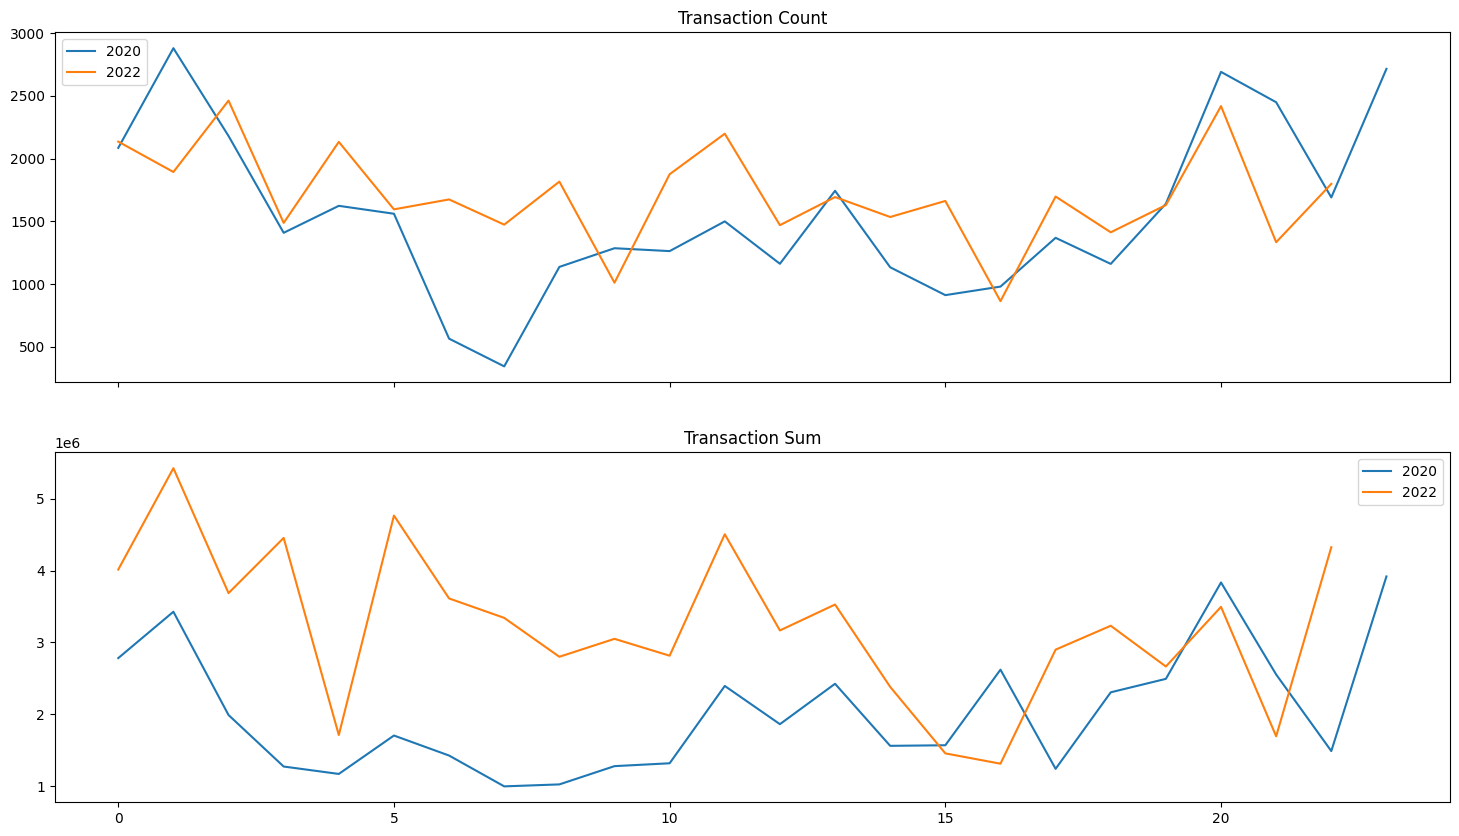

In [373]:
df_txn_count = (dh.df
    .groupby(["Period", "fyear"])
    .txn_amt
    .count()
    .unstack("fyear")
)

df_txn_sum = (dh.df
    .groupby(["Period", "fyear"])
    .txn_amt
    .sum()
    .unstack("fyear")
)

fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (18,10), sharex = True)
pd.concat([df_txn_count[[2020,2022]], df_txn_count[[2021,2023]].set_axis([2020, 2022], axis = 1)]).reset_index(drop = True).plot(ax = axs[0], title= "Transaction Count")
pd.concat([df_txn_sum[[2020,2022]], df_txn_sum[[2021,2023]].set_axis([2020, 2022], axis = 1)]).reset_index(drop = True).plot(ax = axs[1], title = "Transaction Sum")

## Week_fyear Txn_Amt Plot

<Axes: xlabel='period_fyear'>

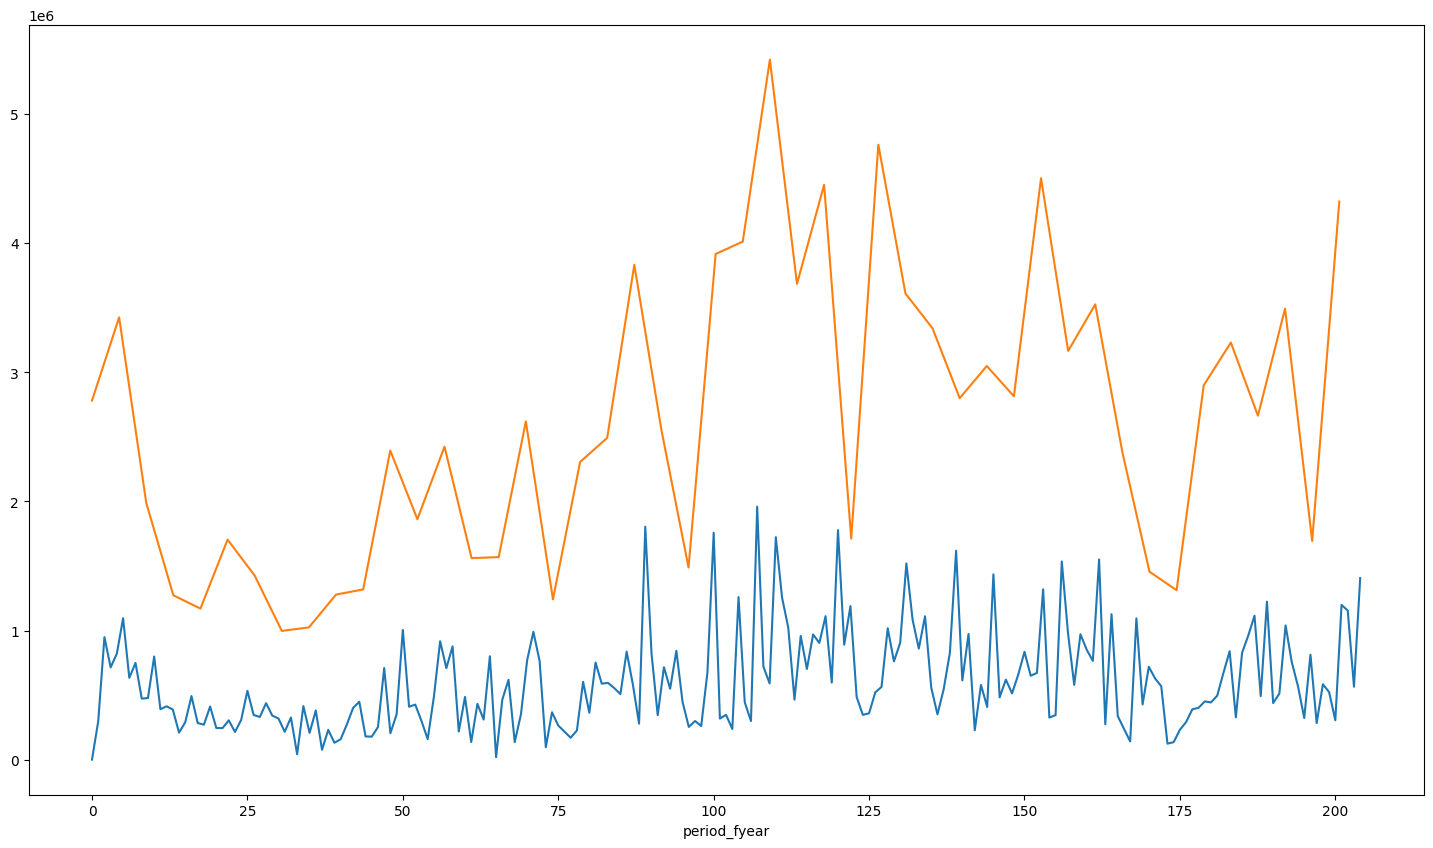

In [480]:
dh.df.groupby("week_fyear").txn_amt.sum().plot(figsize = (18,10))
dh.df.groupby("period_fyear").txn_amt.sum().reset_index().eval("period_fyear = period_fyear*(205/47)").set_index('period_fyear').squeeze().plot(figsize = (18,10))

In [496]:
dh.df.query("period_fyear == 10").groupby("week_fyear").txn_amt.sum().to_frame(name = "10").T#.plot(kind = "bar", stacked = True)

week_fyear,44,45,46,47
10,"179,416.43","177,656.33","251,919.62","709,300.12"


Text(0.5, 1.0, 'Transactions by Week')

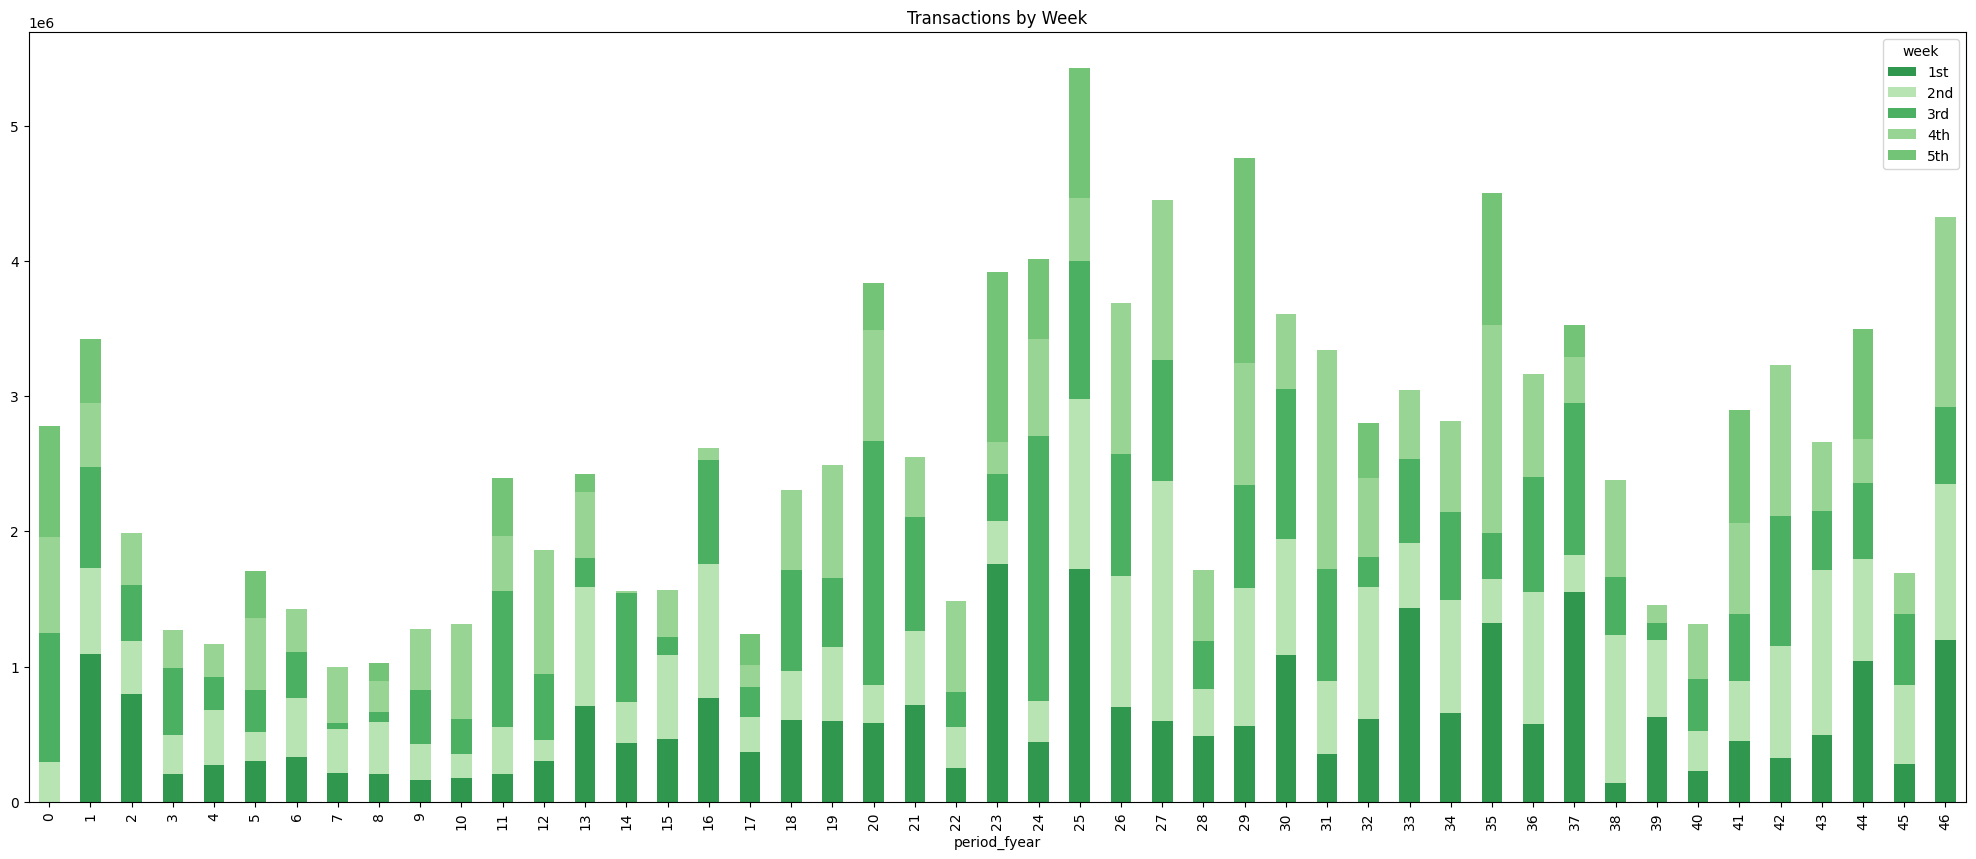

In [560]:
#colormap link: https://matplotlib.org/stable/users/explain/colors/colormaps.html

(dh.df
    .groupby("period_fyear")
    .apply(lambda x: x.groupby("week_fyear").txn_amt.sum().reset_index(drop = True))
    .unstack(level = 1)
    .set_axis(["1st", "2nd", "3rd", "4th", "5th"], axis = 1)
    .fillna(0)
    .plot(
            kind = "bar", 
            stacked = True, 
            figsize = (25,10), 
            color = plt.get_cmap("Greens")((0.7, 0.3, 0.6, 0.4, 0.5))
        )
 )
plt.legend(title = "week")
plt.title("Transactions by Week")


In [531]:
dh.df.groupby("period_fyear").apply(lambda x: x.groupby("week_fyear").txn_amt.sum().reset_index(drop = True)).unstack(level = 1).set_axis(["1st", "2nd", "3rd", "4th", "5th"], axis = 1).fillna(0)

,1st,2nd,3rd,4th,5th
period_fyear,,,,,
0,-32.93,"296,863.12","948,736.06","714,032.35","821,979.33"
1,"1,094,951.74","633,470.46","748,864.70","472,583.76","476,826.27"
2,"798,454.02","390,496.78","413,014.94","387,757.00",0.00
3,"208,550.26","289,291.85","492,104.10","283,052.21",0.00
4,"270,383.61","411,129.17","244,336.70","244,154.78",0.00
...,...,...,...,...,...
42,"327,477.51","827,486.73","961,269.84","1,115,382.36",0.00
43,"491,494.71","1,223,710.72","437,939.66","511,746.73",0.00
44,"1,039,291.68","753,765.87","567,052.31","322,132.35","812,434.24"


## Period_fyear Differenced Plot

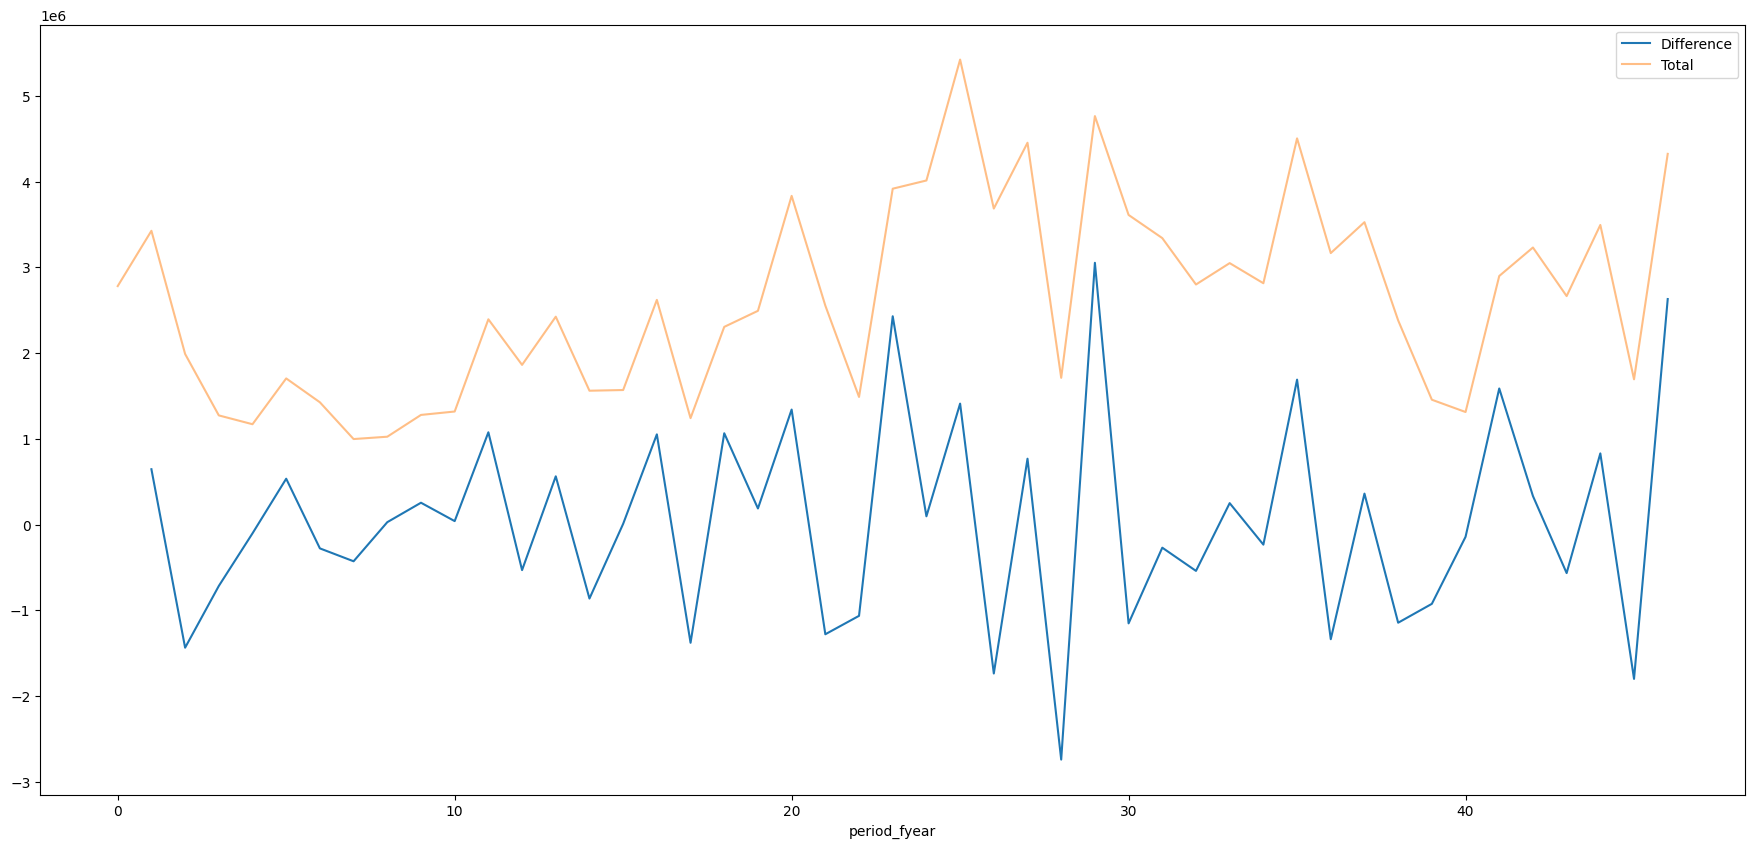

In [570]:
dh.df.groupby("period_fyear").txn_amt.sum().diff().dropna().plot(label = "Difference", figsize = (22,10))
dh.df.groupby("period_fyear").txn_amt.sum().dropna().plot(label = "Total", alpha = 0.5)
plt.legend()